<h1 style="color: 	#365F93;"><strong>Vanguard A/B test</strong></h1>

<h2 style="color: 	#80B1D3;"><strong>Librerias</strong></h2>

In [905]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
from scipy.stats import chi2_contingency, norm
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from matplotlib.colors import LinearSegmentedColormap

sys.path.append(os.path.abspath('../src'))
from eda_insights import *

%matplotlib inline

In [906]:
df_final_demo = pd.read_csv("../data/raw/df_final_demo.txt")
df_exp_cli = pd.read_csv("../data/raw/df_final_experiment_clients.txt")
df_web_1 = pd.read_csv("../data/raw/df_final_web_data_pt_1.txt")
df_web_2 = pd.read_csv("../data/raw/df_final_web_data_pt_2.txt")

<h2 style="color: 	#80B1D3;"><strong>Exploración</strong></h2>

In [907]:
df_final_demo.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0


In [908]:
df_final_demo.shape

(70609, 9)

In [909]:
df_exp_cli.head()

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


In [910]:
df_exp_cli.isna().sum()

client_id        0
Variation    20109
dtype: int64

In [911]:
df_exp_cli.shape

(70609, 2)

In [912]:
df_web_1.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [913]:
df_web_2.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,763412,601952081_10457207388,397475557_40440946728_419634,confirm,2017-06-06 08:56:00
1,6019349,442094451_91531546617,154620534_35331068705_522317,confirm,2017-06-01 11:59:27
2,6019349,442094451_91531546617,154620534_35331068705_522317,step_3,2017-06-01 11:58:48
3,6019349,442094451_91531546617,154620534_35331068705_522317,step_2,2017-06-01 11:58:08
4,6019349,442094451_91531546617,154620534_35331068705_522317,step_1,2017-06-01 11:57:58


<h2 style="color: 	#80B1D3;"><strong>Juntar DFs</strong></h2>

In [914]:
df_web = pd.concat([df_web_1, df_web_2], axis=0)
df_web.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [915]:
df_exp_cli = df_exp_cli[df_exp_cli["Variation"].notna()]

In [916]:
df = pd.merge(df_final_demo, df_exp_cli, on ='client_id',how='inner')
df.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Test
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,Control
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,Test
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,Test
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,Control


In [917]:
df_web['date_time'] = pd.to_datetime(df_web['date_time'], errors='coerce')

<h2 style="color: 	#80B1D3;"><strong>Limpieza del primer DF</strong></h2>

In [918]:
df.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Test
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,Control
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,Test
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,Test
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,Control


In [919]:
df.shape

(50500, 10)

In [920]:
df.dtypes

client_id             int64
clnt_tenure_yr      float64
clnt_tenure_mnth    float64
clnt_age            float64
gendr                object
num_accts           float64
bal                 float64
calls_6_mnth        float64
logons_6_mnth       float64
Variation            object
dtype: object

In [921]:
df['clnt_tenure_yr'].unique()

array([ 6.,  7.,  5., 16., 12., 30., 15.,  8.,  4.,  3., 10., 11., 13.,
       14., 19., 18., 25., 23., 21., 17.,  9., 27., 24., 20., 28., 22.,
       29., 46., 26., 32., 33., 35.,  2., 38., 31., 48., 34., 36., 51.,
       nan, 47., 49., 37., 39., 40., 55., 42., 44., 43., 50., 54., 41.,
       45., 52.])

In [922]:
df['clnt_tenure_yr'] = df['clnt_tenure_yr'].astype('Int64')

In [923]:
df['clnt_tenure_mnth'].unique()

array([ 73.,  94.,  64., 198., 145.,  71.,  66., 361., 369., 189., 100.,
        99.,  67., 193.,  58.,  47., 122., 136., 101., 103.,  70., 152.,
       160.,  80.,  88.,  86.,  65.,  68.,  93.,  85., 168., 142., 228.,
       223., 305., 286., 285., 280., 254., 253., 278., 221., 216., 212.,
       204., 260., 116., 130., 177., 159., 190.,  89.,  91., 129., 329.,
        92.,  82., 169., 239.,  69., 178.,  95.,  63., 187., 288., 261.,
       251., 250.,  56.,  60., 123., 175., 188.,  59., 336., 149., 156.,
       330., 155., 167.,  96., 242., 163.,  81., 182., 134., 113., 172.,
       120., 105., 271., 244., 200., 157.,  78., 151., 121., 184., 335.,
       357., 111., 185.,  76., 148.,  97.,  83., 347., 324., 162., 194.,
        74., 186., 300., 289., 295., 282., 270., 246., 229., 206., 109.,
       343., 176., 144., 161., 179., 106., 154., 119.,  75., 166., 143.,
       202., 326., 298., 290., 279., 252.,  57., 334., 150.,  46., 114.,
       174.,  72., 107., 164., 131., 554., 140., 11

In [924]:
df['clnt_tenure_mnth'] = df['clnt_tenure_mnth'].astype('Int64')

In [925]:
df['clnt_age'].unique()

array([60.5, 58. , 32. , 49. , 33. , 30.5, 58.5, 57.5, 67.5, 54.5, 34.5,
       51.5, 62.5, 36. , 74. , 32.5, 31. , 25.5, 42.5, 42. , 30. , 55. ,
       38. , 68.5, 52.5, 54. , 63. , 48. , 66.5, 68. , 65. , 51. , 46. ,
       63.5, 23. , 26.5, 56.5, 76.5, 27.5, 39.5, 25. , 27. , 60. , 66. ,
       39. , 56. , 40. , 52. , 31.5, 43.5, 35. , 19. , 64.5, 64. , 22.5,
       33.5, 36.5, 61. , 40.5, 72. , 44.5, 28.5, 59.5, 45. , 18. , 78. ,
       50.5, 29. , 37.5, 57. , 70. , 74.5, 22. , 50. , 53. , 62. , 65.5,
       29.5, 28. , 69.5, 35.5, 71.5, 34. , 38.5, 69. , 43. , 83.5, 21.5,
       47. , 61.5, 73.5, 71. , 59. , 21. , 44. , 83. , 47.5, 72.5, 76. ,
       78.5, 55.5, 67. , 41.5, 20.5, 75. , 24. , 79. , 26. , 41. , 23.5,
       49.5, 46.5, 45.5, 48.5, 24.5, 75.5, 80. , 73. , 87. , 19.5, 53.5,
       18.5, 70.5, 80.5, 86. , 37. , 85. , 17.5, 82. , 20. , 77.5, 77. ,
       79.5, 88.5, 96. , 81. , 81.5, 88. , 84. ,  nan, 94.5, 89. , 92. ,
       82.5, 91.5, 85.5, 95.5, 84.5, 90. , 89.5, 93

In [926]:
df['num_accts'].unique()

array([ 2.,  5.,  3.,  4.,  6.,  7., nan,  1.])

In [927]:
df['num_accts'] = df['num_accts'].astype('Int64')

In [928]:
df['calls_6_mnth'].unique()

array([ 6.,  3.,  0.,  2.,  1.,  5.,  4., nan])

In [929]:
df['calls_6_mnth'] = df['calls_6_mnth'].astype('Int64')

In [930]:
df['logons_6_mnth'].unique()

array([ 9.,  6.,  3.,  5.,  4.,  8.,  7., nan])

In [931]:
df['logons_6_mnth'] = df['logons_6_mnth'].astype('Int64')

In [932]:
df.columns = df.columns.str.lower()

In [933]:
df['gendr'].unique()

array(['U', 'M', 'F', nan, 'X'], dtype=object)

In [934]:
df.duplicated().sum()

0

In [935]:
df['gendr'] = df['gendr'].fillna('U')

In [936]:
df.isnull().sum()

client_id            0
clnt_tenure_yr      12
clnt_tenure_mnth    12
clnt_age            13
gendr                0
num_accts           12
bal                 12
calls_6_mnth        12
logons_6_mnth       12
variation            0
dtype: int64

In [937]:
df['clnt_age'] = df['clnt_age'].fillna(df['clnt_age'].mean())

In [938]:
df.dropna(subset=['num_accts'], inplace=True)

<h2 style="color: 	#365F93;"><strong>Análisis</strong></h2>

<h2 style="color: 	#80B1D3;">¿Quienes son los principales clientes que utilizan este proceso en linea?</h2>

In [939]:
# Primero queremos saber que cantidad de gente ha tomado el test.
frequency_table = df['variation'].value_counts()
frequency_table = frequency_table.loc[['Test', 'Control']]

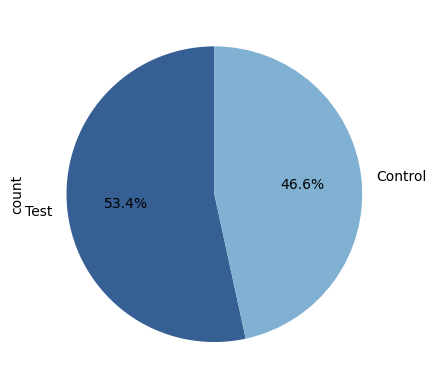

In [940]:
managua_palette = ["#365F93", "#80B1D3", "#DC6236", "#414D58"]
frequency_table.plot.pie(autopct='%1.1f%%', startangle=90)
sns.set_palette(managua_palette)
plt.show()

C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\3865684905.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequency_table.index, y=frequency_table.values, palette=managua_palette[:len(frequency_table)])


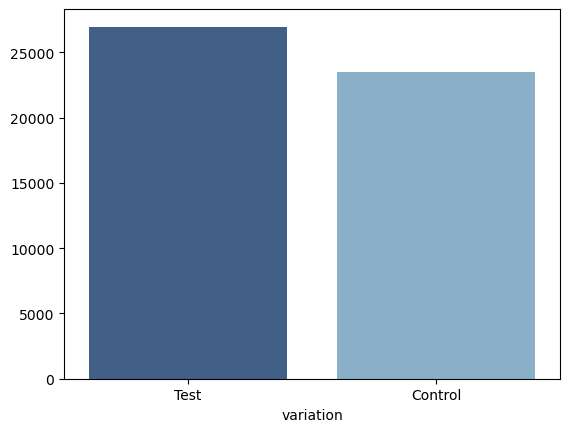

In [941]:
sns.barplot(x=frequency_table.index, y=frequency_table.values, palette=managua_palette[:len(frequency_table)])
plt.show()

<h3 style="color: 	#365F93;">¿Son más bien jóvenes o mayores?</h3>

In [942]:
df['clnt_age'].describe()

count    50488.000000
mean        47.319795
std         15.518462
min         17.000000
25%         33.500000
50%         48.000000
75%         59.500000
max         96.000000
Name: clnt_age, dtype: float64

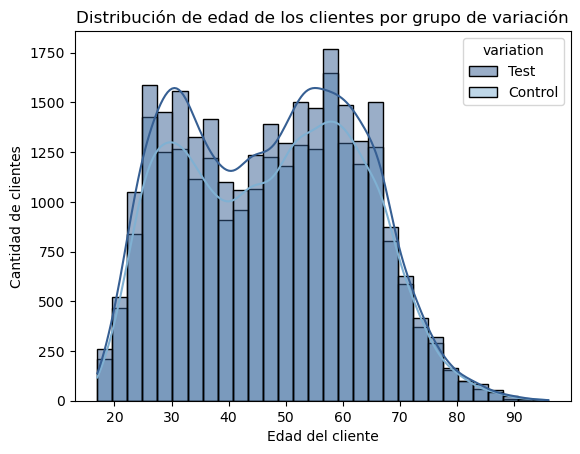

In [943]:
sns.set_palette(managua_palette)
sns.histplot(data=df, x='clnt_age', hue='variation', kde=True, bins=30)
plt.title('Distribución de edad de los clientes por grupo de variación')
plt.xlabel('Edad del cliente')
plt.ylabel('Cantidad de clientes')
plt.show()

Desde los 20 años en adelante, hay una base sólida de usuarios. Esto sugiere que la plataforma online está siendo usada activamente por **adultos jóvenes en adelante**.

Primer pico en los 30s (~35 años):
Probablemente representa a clientes que ya han comenzado a ahorrar/invertir activamente y están cómodos usando herramientas digitales.

Segundo pico en los 50s (~57 años):
Personas en etapa más avanzada de su carrera profesional. Probablemente con más patrimonio y uso activo de servicios financieros, pero también digitalmente competentes.

C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\681142935.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='variation', y='clnt_age', palette=managua_palette)
C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\681142935.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.boxplot(data=df, x='variation', y='clnt_age', palette=managua_palette)


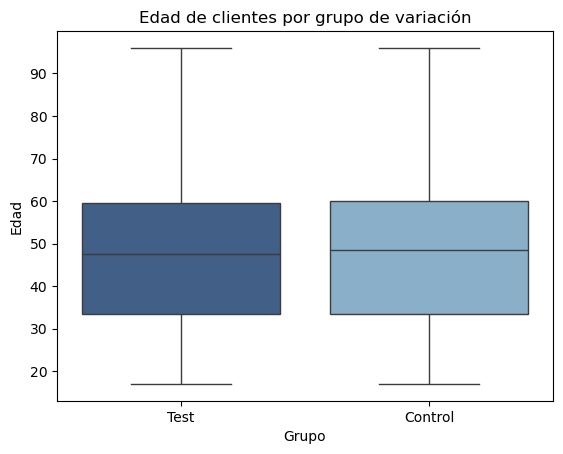

In [944]:
sns.boxplot(data=df, x='variation', y='clnt_age', palette=managua_palette)
plt.title('Edad de clientes por grupo de variación')
plt.xlabel('Grupo')
plt.ylabel('Edad')
plt.show()

Los de test y los de control tienen edades similares.

**Resumen**: 

La mayoría de los clientes que usan el proceso online tienen más de 20 años, con dos grupos destacados alrededor de los 35 y 57 años. Esto indica que tanto adultos jóvenes como clientes de mediana edad son los principales usuarios del proceso digital.

<h3 style="color: 	#365F93;">¿Clientes nuevos o con más antigüedad?</h3>

C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\3231457740.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.histplot(data=df, x='clnt_tenure_mnth', hue='variation', kde=True, bins=30, palette=managua_palette)


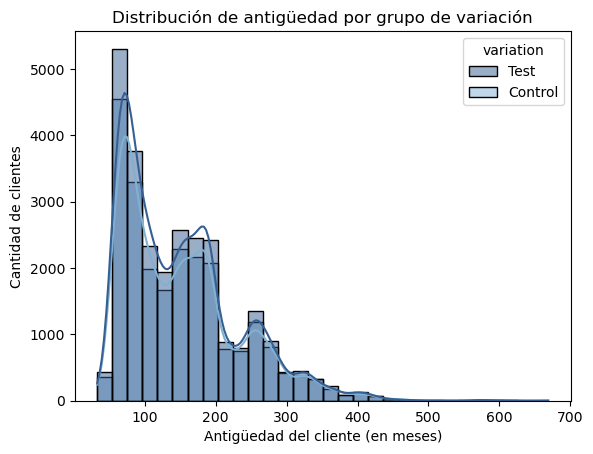

In [945]:
sns.histplot(data=df, x='clnt_tenure_mnth', hue='variation', kde=True, bins=30, palette=managua_palette)
plt.title('Distribución de antigüedad por grupo de variación')
plt.xlabel('Antigüedad del cliente (en meses)')
plt.ylabel('Cantidad de clientes')
plt.show()

C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\1153629069.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='variation', y='clnt_tenure_mnth', palette=managua_palette)
C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\1153629069.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.boxplot(data=df, x='variation', y='clnt_tenure_mnth', palette=managua_palette)


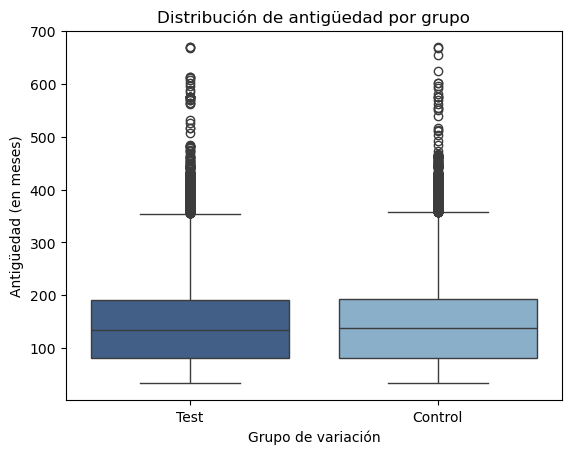

In [946]:
sns.boxplot(data=df, x='variation', y='clnt_tenure_mnth', palette=managua_palette)
plt.title('Distribución de antigüedad por grupo')
plt.xlabel('Grupo de variación')
plt.ylabel('Antigüedad (en meses)')
plt.show()

La antigüedad se mide en meses, y la mayoría de los clientes tienen entre **50 y 80 meses (aproximadamente 4 a 6.5 años)**, donde se observa el pico más alto con cerca de 6000 clientes.

Existe un segundo pico menos pronunciado entre 175 y 200 meses (14.5 a 16.5 años), ceerca de 3000 clientes.

El rango intercuartílico (IQR) de antigüedad — es decir, el 50% central de los clientes — se encuentra entre 100 y 200 meses (aproximadamente 8 a 16 años).

Esto indica que la mayoría de los clientes tienen una antigüedad media a alta, aunque también hay clientes con antiguedades mucho más altas que se consideran outliers en la distribución.

La presencia de estos dos picos y el rango concentrado sugiere que tanto clientes relativamente nuevos como clientes con una larga trayectoria están activos en el proceso online, con una mayor concentración en rangos medios y altos de antigüedad, teniendo en cuenta que interpretamos que 4 años es medio alto.

<h3 style="color: 	#365F93;">¿Tienen sueldos más altos o más bajos?</h3>

C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\2806597684.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.histplot(data=df, x='bal', hue='variation', bins=20, palette=managua_palette, kde=True)


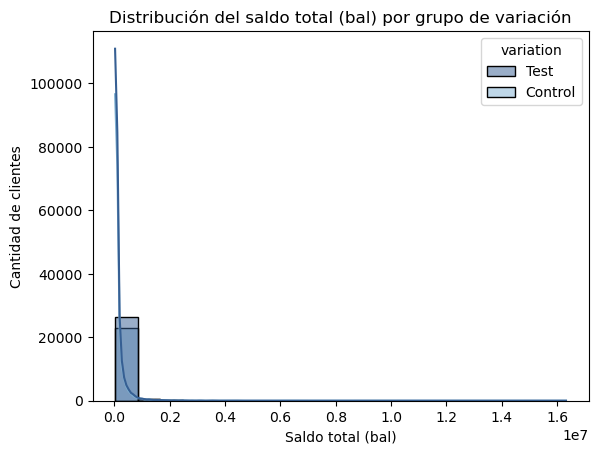

In [947]:
sns.histplot(data=df, x='bal', hue='variation', bins=20, palette=managua_palette, kde=True)
plt.title('Distribución del saldo total (bal) por grupo de variación')
plt.xlabel('Saldo total (bal)')
plt.ylabel('Cantidad de clientes')
plt.show()

C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\2487274542.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='variation', y='bal', palette=managua_palette)
C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\2487274542.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.boxplot(data=df, x='variation', y='bal', palette=managua_palette)


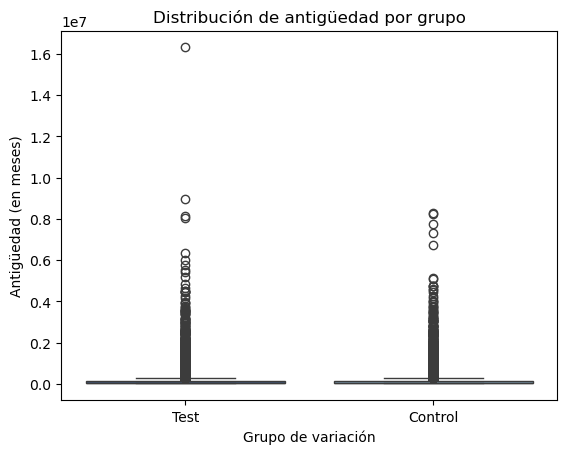

In [948]:
sns.boxplot(data=df, x='variation', y='bal', palette=managua_palette)
plt.title('Distribución de antigüedad por grupo')
plt.xlabel('Grupo de variación')
plt.ylabel('Antigüedad (en meses)')
plt.show()

In [949]:
df.groupby('variation')['bal'].describe()

,count,mean,std,min,25%,50%,75%,max
variation,,,,,,,,
Control,23527.0,150147.326660,295806.950360,23789.61,40123.355,66024.18,140606.045,8292996.21
Test,26961.0,148962.605032,307373.713775,23789.44,39729.200,65468.36,139478.580,16320040.15


La mayoría de los clientes tienen **saldos bajos**, concentrados por debajo de 140,000, con un gran pico en el histograma entre 0 y 20,000, lo que sugiere que muchos clientes tienen cuentas pequeñas.

El IQR (25%–75%) en todos los grupos se encuentra entre aproximadamente **40,000 y 140,000**, mostrando que la mayoría de los clientes se mueve dentro de ese rango de saldo.

Sin embargo, existen outliers muy extremos con saldos millonarios, lo que genera una alta desviación estándar y una gran diferencia entre la media y la mediana.

La mayoría de los clientes tienen saldos pequeños, concentrados por debajo de 200 mil. Sin embargo, existen clientes con saldos muy altos que aparecen como outliers, y estos están presentes en distintos grupos del experimento. Esto podría influir en los resultados si no se controla adecuadamente, por lo que conviene considerar análisis complementarios con y sin estos outliers.

In [950]:
df_bal_clean = filter_outliers_iqr(df, 'bal', lower=False, upper=True)
df_bal_clean.groupby('variation')['bal'].describe()

,count,mean,std,min,25%,50%,75%,max
variation,,,,,,,,
Control,20805.0,80560.606910,58671.669512,23789.61,37871.95,58486.62,103622.37,290044.63
Test,23955.0,80796.455164,59568.779458,23789.44,37652.29,57745.94,103940.19,290073.61


C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\3402996392.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_bal_clean, x='variation', y='bal', palette=managua_palette)
C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\3402996392.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.boxplot(data=df_bal_clean, x='variation', y='bal', palette=managua_palette)


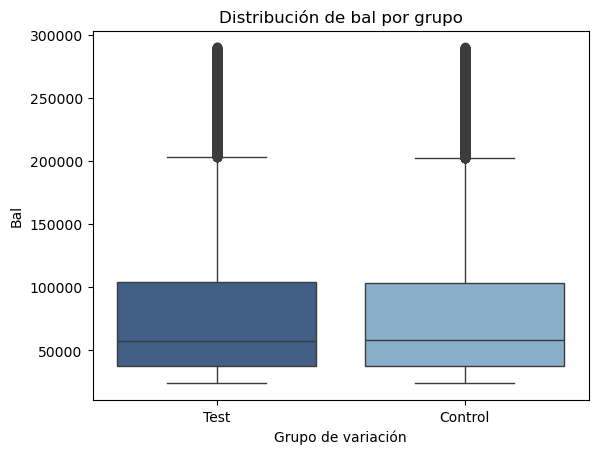

In [951]:
sns.boxplot(data=df_bal_clean, x='variation', y='bal', palette=managua_palette)
plt.title('Distribución de bal por grupo')
plt.xlabel('Grupo de variación')
plt.ylabel('Bal')
plt.show()

Las medias bajan significativamente respecto al análisis con outliers (antes rondaban los 140–150k), lo que confirma que había **valores extremos inflando el promedio**.

Ahora la media y la mediana están más cercanas, lo cual indica una distribución más equilibrada.

Test y Control siguen muy parejos en valores medios, lo que sugiere un reparto equitativo de los clientes por saldo en el experimento.

<h3 style="color: 	#365F93;">Clientes principales</h3>

In [952]:
df.columns

Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth', 'variation'],
      dtype='object')

In [953]:
#Vamos a filtrar nuestros clientes principales
filtro_principales_clientes = (
    (df["clnt_age"] >= 30) & (df["clnt_age"] <= 60) &
    (df["clnt_tenure_mnth"] >= 50) & (df["clnt_tenure_mnth"] <= 200) &
    (df["bal"] >= 30000) & (df["bal"] <= 110000)
)

principales_clientes = df[filtro_principales_clientes]

In [954]:
porcentaje_principales = (len(principales_clientes) / len(df)) * 100
porcentaje_principales

29.842734907304706

In [955]:
principales_clientes["variation"].value_counts()

variation
Test       8063
Control    7004
Name: count, dtype: int64

<h2 style="color: 	#80B1D3;"><strong>Limpieza del segundo DF</strong></h2>

In [956]:
df_web_v = pd.merge(df_web, df_exp_cli, on ='client_id',how='inner')
df_web_v.head()

,client_id,visitor_id,visit_id,process_step,date_time,Variation
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test


In [957]:
df_web_v = df_web_v.drop_duplicates()

<h2 style="color: 	#365F93;"><strong>KPI</strong></h2>

<h3 style="color: 	#80B1D3;"><strong>Tasa de finalizacion</strong></h3>

In [958]:
completed = df_web_v[df_web_v['process_step'] == 'confirm'][['client_id', 'Variation']]
completed

,client_id,Variation
8,8320017,Test
13,4033851,Control
14,4033851,Control
15,4033851,Control
24,1982004,Test
...,...,...
321277,6230585,Test
321282,4977550,Control
321288,6426623,Control
321293,433098,Control


In [959]:
total_clients = df_web_v[['client_id', 'Variation']].groupby('Variation').count()
total_clients

,client_id
Variation,
Control,140536
Test,176699


In [960]:
completed_clients = completed.groupby('Variation').count()
completed_clients

,client_id
Variation,
Control,17336
Test,25600


In [961]:
completion_rate = (completed_clients / total_clients)*100
completion_rate = completion_rate.round(2)
completion_rate

,client_id
Variation,
Control,12.34
Test,14.49


C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\3729426176.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=completion_rate, x='Variation', y='client_id', palette=managua_palette)
C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\3729426176.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.barplot(data=completion_rate, x='Variation', y='client_id', palette=managua_palette)


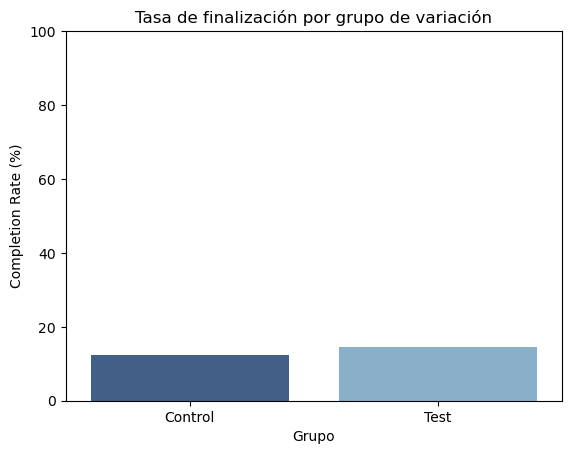

In [962]:
sns.barplot(data=completion_rate, x='Variation', y='client_id', palette=managua_palette)
plt.title('Tasa de finalización por grupo de variación')
plt.ylabel('Completion Rate (%)')
plt.xlabel('Grupo')
plt.ylim(0, 100)
plt.show()

**Insights**

El grupo Test presenta una tasa de finalización del 69.29%, ligeramente superior al 65.59% del grupo Control.

La diferencia es pequeña (menos de 4 puntos porcentuales).

Esta diferencia, aunque moderada en porcentaje, representa unos miles de clientes adicionales que completaron el proceso gracias al nuevo diseño.

La mejora en el grupo Test frente a Control y no_experiment sugiere que la nueva interfaz puede tener un impacto positivo (moderado) en la experiencia y comportamiento de los clientes.

Es importante considerar también otros KPIs para tener una visión más completa del impacto del cambio digital.

<h3 style="color: 	#365F93;">¿Y los clientes principales?</h3>

In [963]:
completed_principales = completed[completed["client_id"].isin(principales_clientes["client_id"])]
completed_principales

,client_id,Variation
24,1982004,Test
49,5887227,Test
73,9814849,Control
79,5407849,Test
128,7286739,Control
...,...,...
321212,3667184,Test
321218,5780472,Control
321224,8895190,Control
321269,1129748,Control


In [964]:
total_clients_principales = principales_clientes[['client_id', 'variation']].drop_duplicates().groupby('variation').count()
total_clients_principales

,client_id
variation,
Control,7004
Test,8063


In [965]:
completed_clients_principales = completed_principales.groupby('Variation').count()
completed_clients_principales

,client_id
Variation,
Control,5055
Test,6913


In [966]:
completion_rate_principales = (completed_clients_principales / total_clients_principales)*100
completion_rate_principales = completion_rate_principales.round(2)
completion_rate_principales

,client_id
Variation,
Control,72.17
Test,85.74


En el caso de nuestros clientes principales control y test se acercan mas en las tasas

<h3 style="color: 	#80B1D3;"><strong>Tiempo invertido en cada paso del proceso</strong></h3>

In [967]:
# Calcular diferencia de tiempo entre pasos del funnel
df_web_sorted = calcular_diferencia_tiempo(df_web_v)

In [968]:
#Muestra
df_web_sorted[df_web_sorted['client_id'] == 9998346]

,client_id,visitor_id,visit_id,process_step,date_time,Variation,time_diff,time_diff_sec
317180,9998346,292425655_16607136645,189177304_69869411700_783154,start,2017-03-29 15:25:00,Control,0 days 00:01:02,62.0
317181,9998346,292425655_16607136645,189177304_69869411700_783154,step_1,2017-03-29 15:26:02,Control,0 days 00:00:45,45.0
317182,9998346,292425655_16607136645,189177304_69869411700_783154,step_2,2017-03-29 15:26:47,Control,0 days 00:00:53,53.0
317183,9998346,292425655_16607136645,189177304_69869411700_783154,step_2,2017-03-29 15:27:40,Control,0 days 00:00:09,9.0
317184,9998346,292425655_16607136645,189177304_69869411700_783154,step_2,2017-03-29 15:27:49,Control,0 days 00:00:11,11.0
317185,9998346,292425655_16607136645,189177304_69869411700_783154,step_3,2017-03-29 15:28:00,Control,0 days 00:01:55,115.0
317186,9998346,292425655_16607136645,189177304_69869411700_783154,step_1,2017-03-29 15:29:55,Control,0 days 00:00:16,16.0
317187,9998346,292425655_16607136645,189177304_69869411700_783154,step_2,2017-03-29 15:30:11,Control,0 days 00:00:14,14.0
317188,9998346,292425655_16607136645,189177304_69869411700_783154,step_3,2017-03-29 15:30:25,Control,0 days 00:07:03,423.0
317189,9998346,292425655_16607136645,189177304_69869411700_783154,step_3,2017-03-29 15:37:28,Control,0 days 00:00:00,0.0


In [969]:
resumen = df_web_sorted.groupby('process_step')['time_diff_sec'] \
             .describe()[['count','mean','std','50%','min','max']]
print(resumen)

                count        mean         std   50%  min      max
process_step                                                     
confirm        6009.0  219.738060  440.695044  76.0  0.0  14581.0
start         82060.0   63.803619  249.031942  16.0  0.0  40235.0
step_1        61570.0   56.358064  147.747437  24.0  0.0  10286.0
step_2        53886.0   90.272928  157.408982  62.0  0.0  21763.0
step_3        44263.0  133.072453  218.740860  65.0  0.0   6692.0


In [970]:
grouped = df_web_sorted.groupby('process_step')['time_diff_sec']

mode = grouped.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

variance = grouped.var()

q75 = grouped.quantile(0.75)
q25 = grouped.quantile(0.25)
iqr = q75 - q25

rango = grouped.max() - grouped.min()

resumen = pd.DataFrame({
    'mode': mode,
    'variance': variance,
    'IQR': iqr,
    'rango': rango
})

In [971]:
resumen

,mode,variance,IQR,rango
process_step,,,,
confirm,0.0,194212.122121,169.0,14581.0
start,4.0,62016.908302,39.0,40235.0
step_1,6.0,21829.305042,41.0,10286.0
step_2,2.0,24777.587623,73.0,21763.0
step_3,26.0,47847.563839,102.0,6692.0


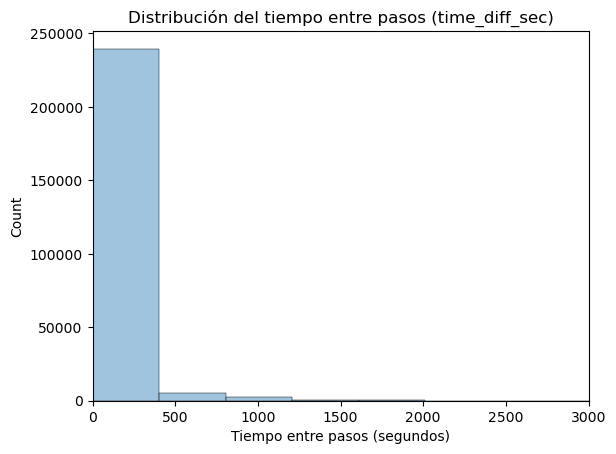

In [972]:
sns.histplot(df_web_sorted['time_diff_sec'], bins=100, kde=False, color='#80B1D3') 
plt.xlim(0, 3000)
plt.title("Distribución del tiempo entre pasos (time_diff_sec)")
plt.xlabel("Tiempo entre pasos (segundos)")
plt.show()

C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\2213407979.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_web_sorted, x='process_step', y='time_diff_sec', palette=managua_palette)
C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\2213407979.py:1: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df_web_sorted, x='process_step', y='time_diff_sec', palette=managua_palette)


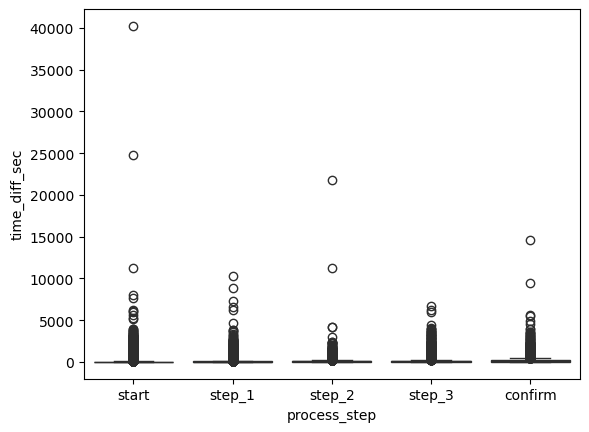

In [973]:
sns.boxplot(data=df_web_sorted, x='process_step', y='time_diff_sec', palette=managua_palette)
plt.show()

In [974]:
#Hay muchos ouliers, vamos a quitarselos
df_time_clean = filter_outliers_iqr(df_web_sorted, 'time_diff_sec', lower=False, upper=True)

In [975]:
q1 = df_time_clean.groupby(['Variation', 'process_step'])['time_diff_sec'].quantile(0.25)
q3 = df_time_clean.groupby(['Variation', 'process_step'])['time_diff_sec'].quantile(0.75)
iqr = q3 - q1
kpis = pd.DataFrame({
    'median': df_time_clean.groupby(['Variation', 'process_step'])['time_diff_sec'].median(),
    'mode': df_time_clean.groupby(['Variation', 'process_step'])['time_diff_sec'].agg(lambda x: x.mode().iloc[0]),
    'IQR': iqr
})
kpis

median  mode   IQR
Variation process_step                    
Control   confirm         32.0   0.0  60.0
          start           18.0   4.0  31.0
          step_1          19.0   6.0  34.0
          step_2          58.0   4.0  64.0
          step_3          58.0  34.0  61.0
Test      confirm         58.0  27.0  70.0
          start           13.0   4.0  27.0
          step_1          25.0  10.0  35.0
          step_2          56.0   2.0  59.0
          step_3          46.0  26.0  54.0

C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\2102088705.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.boxplot(data=df_time_clean, x='process_step', y='time_diff_sec', hue='Variation', showfliers=False,  palette=managua_palette)


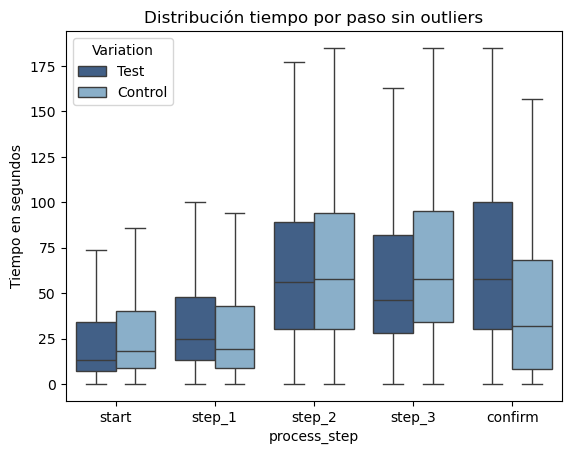

In [976]:
sns.boxplot(data=df_time_clean, x='process_step', y='time_diff_sec', hue='Variation', showfliers=False,  palette=managua_palette)
plt.title('Distribución tiempo por paso sin outliers')
plt.ylabel('Tiempo en segundos')
plt.show()

C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\1805419543.py:2: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.barplot(data=df_time_clean, x='process_step', y='time_diff_sec', hue='Variation',estimator=np.median, palette=managua_palette)


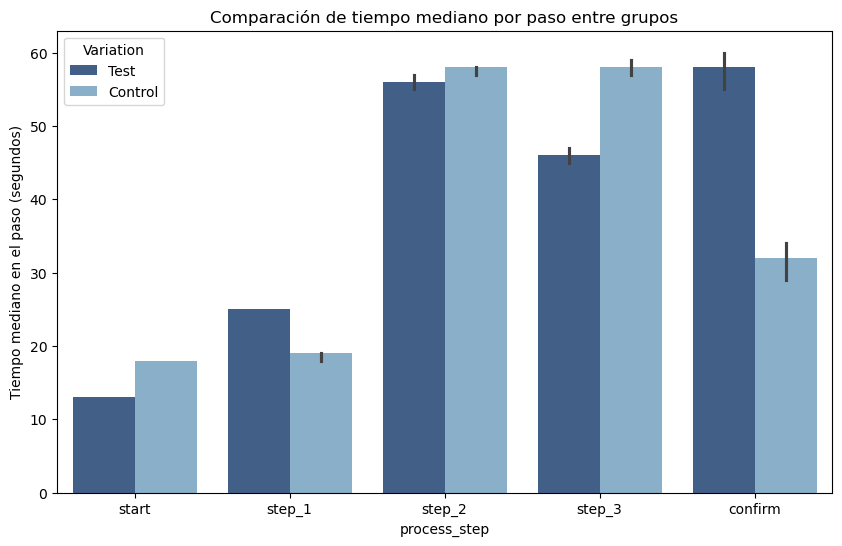

In [977]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_time_clean, x='process_step', y='time_diff_sec', hue='Variation',estimator=np.median, palette=managua_palette)
plt.ylabel('Tiempo mediano en el paso (segundos)')
plt.title('Comparación de tiempo mediano por paso entre grupos')
plt.show()

Tras limpiar los datos de valores extremos, observamos que:


El grupo **Control** presenta tiempos medianos consistentemente **más altos** en varios pasos clave del proceso (start, step_2, step_3), lo cual podría indicar mayor fricción o menor eficiencia con la versión antigua del diseño.

El grupo **Test**, tras la implementación del rediseño, muestra tiempos **más bajos** en la mayoría de los pasos, excepto en step_1 y confirm.

En confirm, donde no debería haber prácticamente tiempos (porque debería ser el último paso), se observan valores inesperadamente altos en Test , lo que refuerza una hipótesis de errores de navegación o desviaciones del flujo esperado.

El hecho de que la moda sea 0 en confirm, sugiere que en muchos casos los usuarios son enviados directamente al siguiente paso sin tiempo intermedio, lo cual puede deberse a errores técnicos, repeticiones o flujos mal definidos.

En resumen, Test parece que muestra un proceso más ágil y consistente, mientras que Control refleja mayores tiempos y más evidencias de errores.

<h3 style="color: 	#365F93;">¿Y los clientes principales?</h3>

In [978]:
principales_time_clean = df_time_clean[df_time_clean["client_id"].isin(principales_clientes["client_id"])]

In [979]:
q1 = principales_time_clean.groupby(['Variation', 'process_step'])['time_diff_sec'].quantile(0.25)
q3 = principales_time_clean.groupby(['Variation', 'process_step'])['time_diff_sec'].quantile(0.75)
iqr = q3 - q1
kpis = pd.DataFrame({
    'median': principales_time_clean.groupby(['Variation', 'process_step'])['time_diff_sec'].median(),
    'mode': principales_time_clean.groupby(['Variation', 'process_step'])['time_diff_sec'].agg(lambda x: x.mode().iloc[0]),
    'IQR': iqr
})
kpis

median  mode   IQR
Variation process_step                    
Control   confirm         31.0   0.0  67.0
          start           17.0   4.0  29.0
          step_1          17.0   6.0  29.0
          step_2          69.0   4.0  68.0
          step_3          56.0  41.0  57.0
Test      confirm         59.0  59.0  69.5
          start           12.0   4.0  25.0
          step_1          23.0   9.0  31.0
          step_2          66.0   1.0  59.0
          step_3          43.0  22.0  51.0

C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\3554963030.py:2: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.barplot(data=principales_time_clean, x='process_step', y='time_diff_sec', hue='Variation',estimator=np.median, palette=managua_palette)


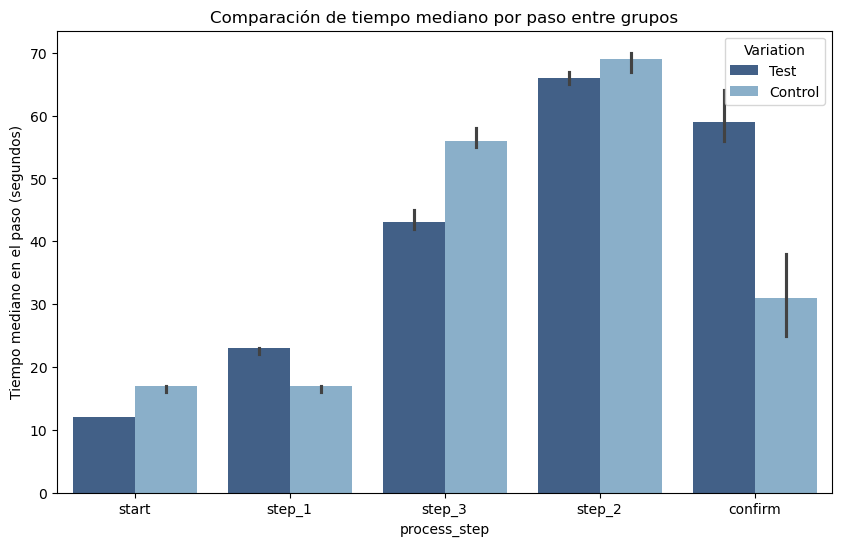

In [980]:
plt.figure(figsize=(10, 6))
sns.barplot(data=principales_time_clean, x='process_step', y='time_diff_sec', hue='Variation',estimator=np.median, palette=managua_palette)
plt.ylabel('Tiempo mediano en el paso (segundos)')
plt.title('Comparación de tiempo mediano por paso entre grupos')
plt.show()

<h3 style="color: 	#80B1D3;"><strong>Tasa de error</strong></h3>

<h3 style="color: 	#365F93;">¿Que es un error?</h3>

- Repetir pasos, que se carguen dos veces, errores en el backend de la web, como multiples step 2.

- Que nos devuelva a pasos anteriores como de el step 3 al 1.

- time_diff = 0 

In [981]:
df_web_sorted = detectar_errores_funnel(df_web_sorted)

In [982]:
tasa_errores = calcular_tasa(df_web_sorted, 'es_error')
print(f"Tasa de errores técnicos en el funnel: {tasa_errores:.2f}%")

Tasa de errores técnicos en el funnel: 0.13%


In [983]:
# Ver cuántos retrocesos ocurren en cada paso
retrocesos_por_paso = df_web_sorted[df_web_sorted['es_error'] == True].groupby('process_step').size().reset_index(name='es_error')
print(retrocesos_por_paso)

  process_step  es_error
0      confirm       117
1        start         2
2       step_1        38
3       step_2        54
4       step_3       194


In [984]:
retrocesos_por_paso = df_web_sorted[df_web_sorted['salto_grande_adelante'] == True].groupby('process_step').size().reset_index(name='es_error')
print(retrocesos_por_paso)

  process_step  es_error
0       step_2        14
1       step_3         6


In [985]:
retrocesos_por_paso = df_web_sorted[df_web_sorted['repetido_mismo_paso'] == True].groupby('process_step').size().reset_index(name='es_error')
print(retrocesos_por_paso)

  process_step  es_error
0        start         2
1       step_1         6
2       step_2        29
3       step_3       162


In [986]:
retrocesos_por_paso = df_web_sorted[df_web_sorted['retroceso_cero'] == True].groupby('process_step').size().reset_index(name='es_error')
print(retrocesos_por_paso)

  process_step  es_error
0      confirm       117
1       step_1         8
2       step_2        25
3       step_3        32


In [987]:
retrocesos_por_paso = df_web_sorted[df_web_sorted['salto_grande_atras'] == True].groupby('process_step').size().reset_index(name='es_error')
print(retrocesos_por_paso)

  process_step  es_error
0       step_1        24


In [988]:
df_tasa_error_variation = calcular_tasa(df_web_sorted, 'es_error', grupo_col='Variation', step_col='process_step')
print(df_tasa_error_variation)

  Variation process_step  total_registros  n_eventos    tasa_%
0   Control      confirm            17336      100.0  0.576834
1   Control        start            45380        0.0  0.000000
2   Control       step_1            29544       12.0  0.040617
3   Control       step_2            25773       16.0  0.062080
4   Control       step_3            22503      143.0  0.635471
5      Test      confirm            25600       17.0  0.066406
6      Test        start            55773        2.0  0.003586
7      Test       step_1            38666       26.0  0.067243
8      Test       step_2            30899       38.0  0.122981
9      Test       step_3            25761       51.0  0.197974


  Variation   total  errores  tasa_error_%
0   Control  140536      271      0.192833
1      Test  176699      134      0.075835


C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\3401708836.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_error_summary, x='Variation', y='tasa_error_%', palette=managua_palette)
C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\3401708836.py:12: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.barplot(data=df_error_summary, x='Variation', y='tasa_error_%', palette=managua_palette)


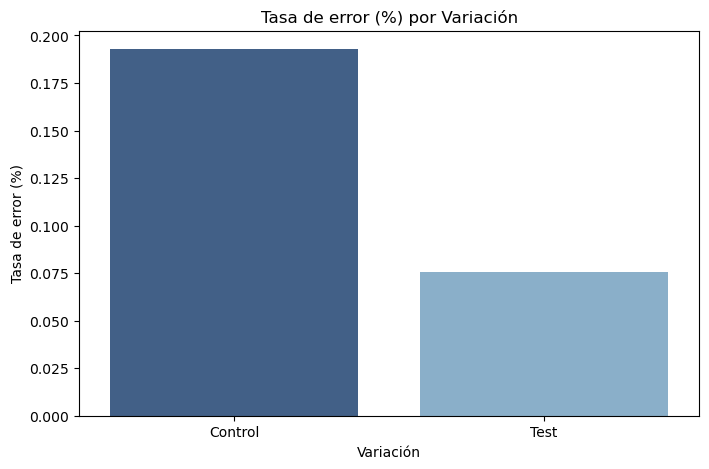

In [989]:
df_error_summary = df_web_sorted.groupby('Variation').agg(
    total=('client_id', 'count'),
    errores=('es_error', 'sum')
).reset_index()

df_error_summary['tasa_error_%'] = (df_error_summary['errores'] / df_error_summary['total']) * 100

print(df_error_summary)


plt.figure(figsize=(8,5))
sns.barplot(data=df_error_summary, x='Variation', y='tasa_error_%', palette=managua_palette)
plt.title('Tasa de error (%) por Variación')
plt.ylabel('Tasa de error (%)')
plt.xlabel('Variación')
plt.show()

C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\357497632.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.barplot(data=df_tasa_error_variation, x='process_step', y='tasa_%', hue='Variation', palette=managua_palette)


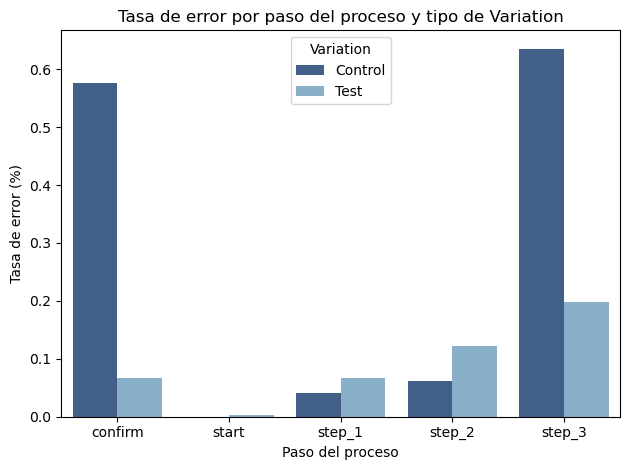

In [990]:
sns.barplot(data=df_tasa_error_variation, x='process_step', y='tasa_%', hue='Variation', palette=managua_palette)

plt.title('Tasa de error por paso del proceso y tipo de Variation')
plt.ylabel('Tasa de error (%)')
plt.xlabel('Paso del proceso')
plt.legend(title='Variation')
plt.tight_layout()
plt.show()

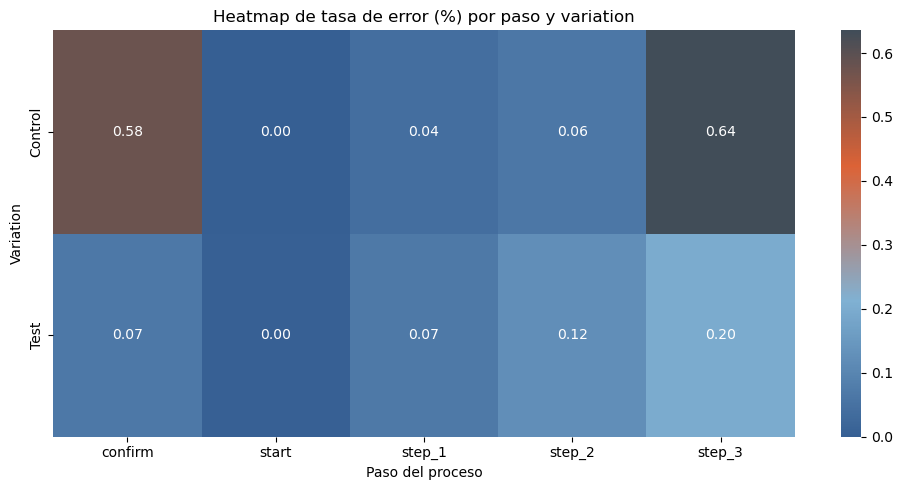

In [991]:
df_heatmap = df_tasa_error_variation.pivot(index='Variation', columns='process_step', values='tasa_%')
managua_cmap = LinearSegmentedColormap.from_list("managua_cmap", managua_palette)
plt.figure(figsize=(10, 5))
sns.heatmap(df_heatmap, annot=True, fmt=".2f", cmap=managua_cmap)

plt.title('Heatmap de tasa de error (%) por paso y variation')
plt.ylabel('Variation')
plt.xlabel('Paso del proceso')
plt.tight_layout()
plt.show()

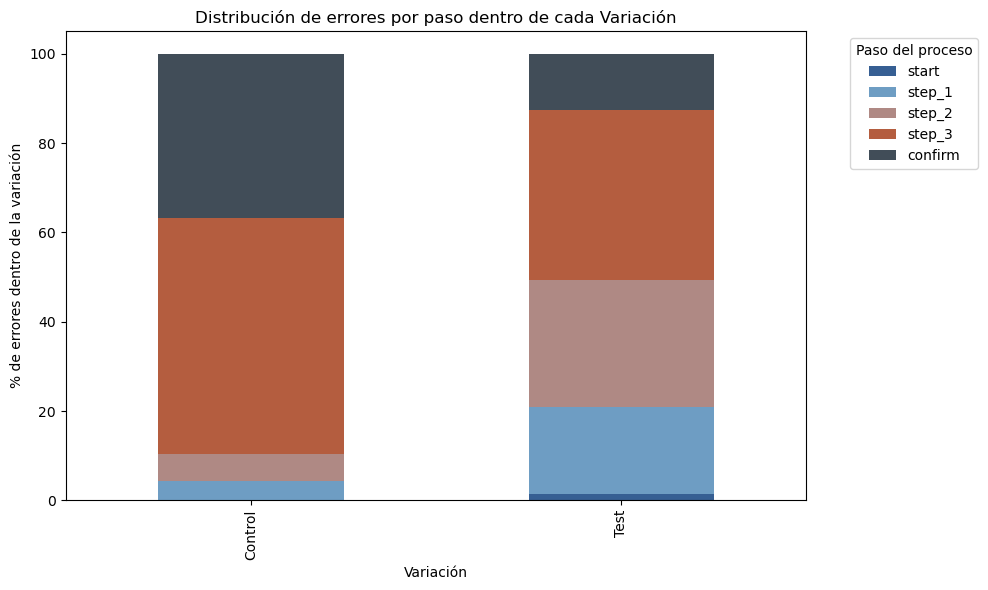

In [992]:
#Tasa de errores por variación
df_errores = df_web_sorted[df_web_sorted['es_error'] == True]

errores_por_paso = df_errores.groupby(['Variation', 'process_step']).size().reset_index(name='n_errores')

errores_por_paso['%_dentro_variation'] = errores_por_paso.groupby('Variation')['n_errores'].transform(lambda x: (x / x.sum()) * 100)

df_pivot = errores_por_paso.pivot(index='Variation', columns='process_step', values='%_dentro_variation').fillna(0)

df_pivot = df_pivot[['start', 'step_1', 'step_2', 'step_3', 'confirm']]  # Asegurar orden

df_pivot.plot(kind='bar', stacked=True, figsize=(10,6), colormap=managua_cmap)
plt.title('Distribución de errores por paso dentro de cada Variación')
plt.ylabel('% de errores dentro de la variación')
plt.xlabel('Variación')
plt.legend(title='Paso del proceso', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\285898355.py:5: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


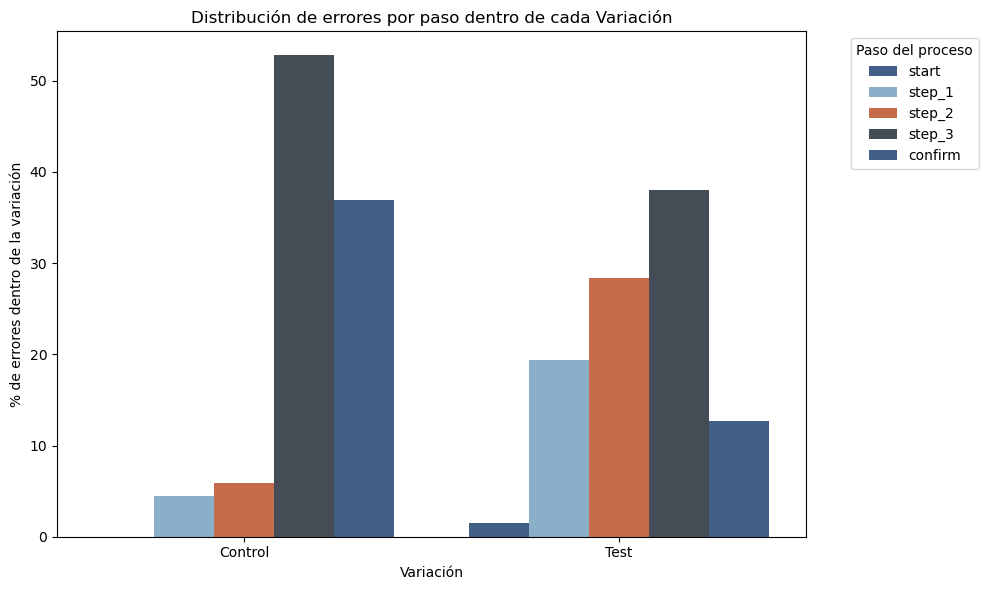

In [993]:
orden_pasos = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
errores_por_paso['process_step'] = pd.Categorical(errores_por_paso['process_step'], categories=orden_pasos, ordered=True)

plt.figure(figsize=(10,6))
sns.barplot(
    data=errores_por_paso,
    x='Variation',
    y='%_dentro_variation',
    hue='process_step',
    hue_order=orden_pasos,
    palette=managua_palette
)
plt.title('Distribución de errores por paso dentro de cada Variación')
plt.ylabel('% de errores dentro de la variación')
plt.xlabel('Variación')
plt.legend(title='Paso del proceso', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

1. Visión global de la tasa de errores en el funnel
- Tasa de errores técnicos sobre el total de interacciones: 0.13 %.
- Esto significa que, de cada 1000 sesiones, solo 1 presenta algún fallo en el proceso.

2. Número de retrocesos totales por paso
- El inicio (“start”) tiene poquísimos errores, prácticamente nada
- El paso step_1, step_2 y confirm tienen entre 100 y 200 errores y en el step_3 se dispara hasta los 311.

3. Satlo grande hacia adelante
- Es prácticamente insignificante, solo hay poquísimos fallos en el step_2 y el step_3

3. Repetición del mismo paso (mismo process_step)
- En el primer paso (start) prácticmanete no hay errores de este tipo
- En el step_1 y step_2 va aumentando el número de errores de forma paulatina
- En el step_3 aumenta mucho respecto a los anteriores
- El hecho de que un usuario “repita” la misma pantalla sin avanzar puede indicar validaciones que fallan sin mostrar mensajes claros, o bien problemas de performance que inducen a recargar la página.
- Especialmente preocupante el step_3, donde probablemente hay validaciones o campos que confunden.
- También preocupa que, en cuanto a este tipo de errores, se empiece prácticamente sin fallos y vaya aumentando a medida que se abanza en los pasos

4. Retrocesos instantáneos (tiempo = 0 s)
- Son casos en que el usuario retrocede de un paso a otro anterior sin pasar tiempo, lo cual no es usuario-intencionado sino error técnico de navegación, según nuestra interpretación
- El mayor volumen está en el confirm (185), lo que puede suponer que, tras completar todo, algunos usuarios son devueltos a pantallas anteriores sin querer.

5. Saltos de más de un paso (imposibles en flujo normal)
- Un usuario “brinca” de step_3 directamente a start (o similares), lo cual no puede ser un comportamiento legítimo.
- La gran mayoría se concentran en el step_1, en start y step_2 es insignificante

Hasta aquí, hemos analizado los errores en general, sin discriminar entre el grupo Test y Control.

Vamos a ver las diferencias entre la nueva web y la vieja:

- En el primer paso (start), en el grupo Test aumenta de 0 a 2, no es muy relevante.
- En el step_1, en el grupo Test se duplican los errores
- En el step_2, el grupo Test aumenta pero muy poco y son cifras bajas en general (16 errores el grupo control y 38 el Test)
- En el step_3, con la nueva web se reduce 1/3 aproximadamente
- En el último paso (confirm) se reduce mucho y prácticamente no hay errores en Test (17)

- En total, se pasa de un 0.19% de errores en el grupo Control a un 0.07% en el grupo Test, cosa que indica una mejora. En confirm disminuye muchísimo para el grupo Test, igual que en el step_3. En start, step_1 y step_2, el grupo Test tiene más errores pero son cifras muy bajas. En concreto en el start, en el grupo Control hay 0 errores y en Test si que existen pero muy anecdóticos.

<h3 style="color: 	#365F93;">¿Y los clientes principales?</h3>

In [994]:
principales_web = df_web_sorted[df_web_sorted["client_id"].isin(principales_clientes["client_id"])]

In [995]:
tasa_errores = calcular_tasa(principales_web, 'es_error')
print(f"Tasa de errores técnicos en el funnel: {tasa_errores:.2f}%")

Tasa de errores técnicos en el funnel: 0.12%


In [996]:
tasa_error_variacion = calcular_tasa(principales_web, 'es_error', grupo_col='Variation')
print(tasa_error_variacion)

Variation
Control    0.197653
Test       0.060285
Name: es_error, dtype: float64


Ha bajado la tasa de errores general, pero ha subido ligeramente control.
La bajada de la tasa de errores es gracias a que Test ha bajado.

<h2 style="color: 	#365F93;"><strong>Más KPIs</strong></h2>

<h3 style="color: 	#80B1D3;"><strong>Tasa de éxito primer intento</strong></h3>

In [997]:
completed = df_web_sorted[df_web_sorted['process_step'] == 'confirm']['client_id'].unique()
df_completed_clients = df_web_sorted[df_web_sorted['client_id'].isin(completed)]

In [998]:
df_valid = df_completed_clients[
    (df_completed_clients['es_error'] == False) &
    (df_completed_clients['repetido_mismo_paso'] == False) &
    (df_completed_clients['retroceso_cero'] == False) &
    (df_completed_clients['salto_grande_atras'] == False)
]

In [999]:
ruta_ideal = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
step_sequences = df_valid.groupby('client_id')['process_step'].apply(list)

first_attempt_success = []

for client_id, seq in step_sequences.items():
    if seq == ruta_ideal:
        first_attempt_success.append(True)
    else:
        first_attempt_success.append(False)

first_attempt_success_df = pd.DataFrame({
    'client_id': list(step_sequences.index),
    'first_attempt_success': first_attempt_success
})

df_merged = first_attempt_success_df.merge(df_exp_cli, on='client_id', how='inner')


In [1000]:
sum_exito = first_attempt_success_df['first_attempt_success'].value_counts()
sum_por_grupo = df_merged.groupby('Variation')['first_attempt_success'].sum()
sum_exito,sum_por_grupo

(first_attempt_success
 False    18646
 True     15475
 Name: count, dtype: int64,
 Variation
 Control    7314
 Test       8161
 Name: first_attempt_success, dtype: int64)

In [1001]:
tasa_exito = calcular_tasa(first_attempt_success_df, 'first_attempt_success')
tasa_por_grupo = calcular_tasa(df_merged, 'first_attempt_success', grupo_col='Variation')
tasa_exito, tasa_por_grupo

(45.35330148588845,
 Variation
 Control    47.388882
 Test       43.672071
 Name: first_attempt_success, dtype: float64)

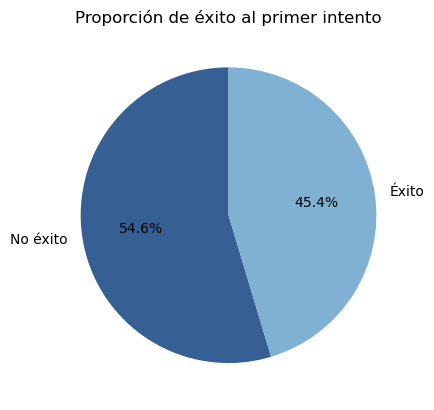

In [1002]:
labels = ['No éxito', 'Éxito']
plt.pie(sum_exito, labels=labels, autopct='%1.1f%%', colors=managua_palette, startangle=90)
plt.title('Proporción de éxito al primer intento')
plt.show()

C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\2598918270.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=success_rate, x='Variation', y='success_rate', palette=managua_palette)
C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\2598918270.py:12: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.barplot(data=success_rate, x='Variation', y='success_rate', palette=managua_palette)


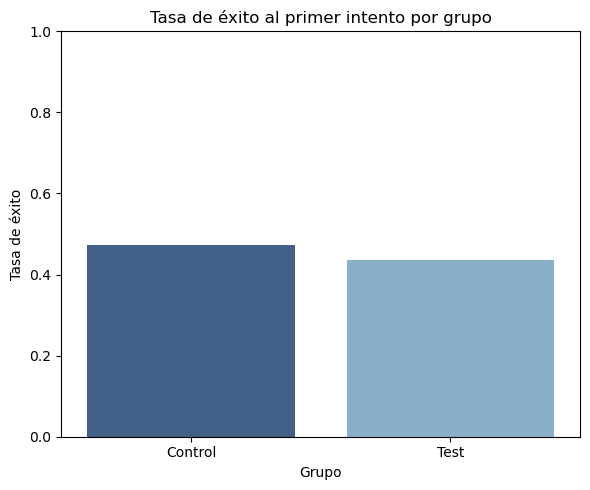

In [1003]:
# Total de usuarios únicos por grupo
total_by_group = df_merged.groupby('Variation')['client_id'].nunique()

# Usuarios con éxito al primer intento por grupo
success_by_group = df_merged[df_merged['first_attempt_success'] == True].groupby('Variation')['client_id'].nunique()

# Calcular tasa
success_rate = (success_by_group / total_by_group).reset_index(name='success_rate')

# Gráfico de barras
plt.figure(figsize=(6, 5))
sns.barplot(data=success_rate, x='Variation', y='success_rate', palette=managua_palette)

plt.title('Tasa de éxito al primer intento por grupo')
plt.ylabel('Tasa de éxito')
plt.xlabel('Grupo')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

- El test finaliza más procesos que el control (69% vs. 65.6%), pero tiene peor desempeño en el primer intento.

- Esto sugiere que el test permite recuperar más abandonos o errores, aunque el flujo no sea tan claro desde el inicio, ya que tiene menor tasa de éxito al primer intento (43.7% vs. 47.4%).

- El control tiene una mayor tasa de éxito al primer intento, a pesar de registrar más errores técnicos en pasos finales.

- Esto indica que el flujo del control, aunque más frágil técnicamente, es más directo o intuitivo para el usuario.

- El test reduce los errores técnicos al final del proceso, pero introduce más fricción en pasos intermedios, lo que afecta negativamente la tasa de éxito al primer intento.

- La experiencia del test parece más tolerante a errores, pero menos clara desde el comienzo.

- En resumen: los usuarios del test necesitan más de un intento para completar el proceso, aunque finalmente lo logren.

<h3 style="color: 	#365F93;">¿Y los clientes principales?</h3>

In [1004]:
principales_frist = first_attempt_success_df[first_attempt_success_df["client_id"].isin(principales_clientes["client_id"])]

In [1005]:
principales_merged = df_merged[df_merged["client_id"].isin(principales_clientes["client_id"])]

In [1006]:
sum_exito = principales_frist['first_attempt_success'].value_counts()
sum_por_grupo = principales_merged.groupby('Variation')['first_attempt_success'].sum()
sum_exito,sum_por_grupo

(first_attempt_success
 False    5107
 True     5001
 Name: count, dtype: int64,
 Variation
 Control    2416
 Test       2585
 Name: first_attempt_success, dtype: int64)

In [1007]:
tasa_exito = calcular_tasa(principales_frist, 'first_attempt_success')
tasa_por_grupo = calcular_tasa(principales_merged, 'first_attempt_success', grupo_col='Variation')
tasa_exito, tasa_por_grupo

(49.47566284131381,
 Variation
 Control    51.956989
 Test       47.361671
 Name: first_attempt_success, dtype: float64)

<h3 style="color: 	#80B1D3;"><strong>Tiempo total por cliente</strong></h3>

In [1008]:
# Agrupar por cliente y variation, sumar el tiempo en segundos en todos los pasos
tiempo_total_cliente = df_web_sorted.groupby(['client_id', 'Variation'])['time_diff_sec'].sum().reset_index()
tiempo_total_cliente.rename(columns={'time_diff_sec': 'total_time_sec'}, inplace=True)

tiempo_total_cliente.head()

,client_id,Variation,total_time_sec
0,555,Test,158.0
1,647,Test,377.0
2,934,Test,142.0
3,1028,Control,538.0
4,1104,Control,0.0


In [1009]:
desc_stats = tiempo_total_cliente.groupby('Variation')['total_time_sec'].describe()
desc_stats

,count,mean,std,min,25%,50%,75%,max
Variation,,,,,,,,
Control,23532.0,384.349184,656.790705,0.0,111.0,231.0,440.0,42099.0
Test,26968.0,435.190782,732.827036,0.0,122.0,234.0,475.0,31624.0


C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\3209830885.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=tiempo_total_cliente, x='Variation', y='total_time_sec', palette=managua_palette)
C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\3209830885.py:2: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.boxplot(data=tiempo_total_cliente, x='Variation', y='total_time_sec', palette=managua_palette)


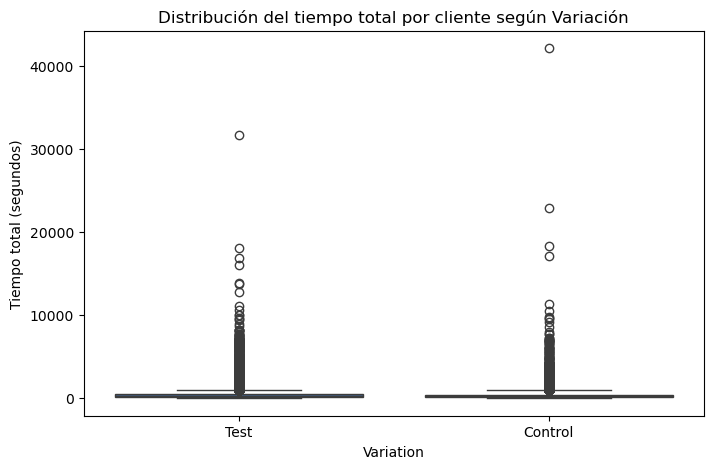

In [1010]:
plt.figure(figsize=(8,5))
sns.boxplot(data=tiempo_total_cliente, x='Variation', y='total_time_sec', palette=managua_palette)
plt.title('Distribución del tiempo total por cliente según Variación')
plt.ylabel('Tiempo total (segundos)')
plt.show()

In [1011]:
tiempo_filtrado = filter_outliers_iqr(tiempo_total_cliente, 'total_time_sec', lower=True, upper=True)

In [1012]:
desc_stats = tiempo_filtrado.groupby('Variation')['total_time_sec'].describe()
desc_stats

,count,mean,std,min,25%,50%,75%,max
Variation,,,,,,,,
Control,21645.0,259.213906,219.475981,0.0,100.0,210.0,366.0,965.0
Test,24283.0,267.071532,217.393922,0.0,113.0,205.0,373.0,965.0


C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\1363235952.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=tiempo_filtrado, x='Variation', y='total_time_sec', palette=managua_palette)
C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\1363235952.py:2: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.boxplot(data=tiempo_filtrado, x='Variation', y='total_time_sec', palette=managua_palette)


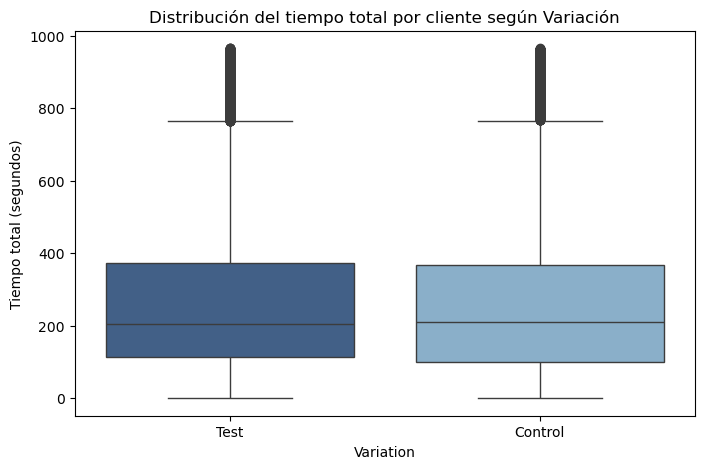

In [1013]:
plt.figure(figsize=(8,5))
sns.boxplot(data=tiempo_filtrado, x='Variation', y='total_time_sec', palette=managua_palette)
plt.title('Distribución del tiempo total por cliente según Variación')
plt.ylabel('Tiempo total (segundos)')
plt.show()



Control y Test tienen tiempos totales muy similares en media (~260s) y dispersión.

La mediana de tiempo total es muy similar en Control (210s) y Test (205s), lo que indica que el tiempo típico que tardan los usuarios en completar el proceso es casi el mismo en ambos grupos.

Percentiles 25 y 75 son parecidos en ambos grupos, mostrando rangos de tiempo similares.

<h3 style="color: 	#365F93;">¿Y los clientes principales?</h3>

In [1014]:
principales_total = tiempo_filtrado[tiempo_filtrado["client_id"].isin(principales_clientes["client_id"])]

In [1015]:
desc_stats = principales_total.groupby('Variation')['total_time_sec'].describe()
desc_stats

,count,mean,std,min,25%,50%,75%,max
Variation,,,,,,,,
Control,6487.0,256.806536,216.966041,0.0,101.0,209.0,360.0,965.0
Test,7393.0,258.517652,214.008482,0.0,110.0,200.0,356.0,964.0


C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\3769198150.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=principales_total, x='Variation', y='total_time_sec', palette=managua_palette)
C:\Users\rocio\AppData\Local\Temp\ipykernel_27944\3769198150.py:2: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.boxplot(data=principales_total, x='Variation', y='total_time_sec', palette=managua_palette)


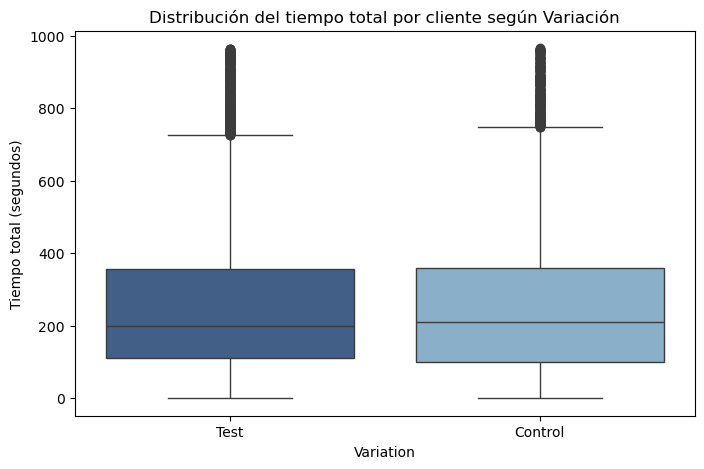

In [1016]:
plt.figure(figsize=(8,5))
sns.boxplot(data=principales_total, x='Variation', y='total_time_sec', palette=managua_palette)
plt.title('Distribución del tiempo total por cliente según Variación')
plt.ylabel('Tiempo total (segundos)')
plt.show()

<h4 style="color: #80B1D3;"><strong>Resumen Final de KPIs</strong></h4>
🧩 1. Completitud del proceso
Grupo Test finaliza más procesos que Control en términos generales (69.3% vs. 65.6%).

Entre los clientes principales, las tasas se acercan: 67% Test vs. 66% Control.

Esto indica que el nuevo diseño mejora la conversión global, aunque su impacto en el segmento clave es más moderado.

🎯 2. Éxito al primer intento
A nivel general, Control tiene una mayor tasa de éxito al primer intento (47.4%) que Test (43.7%).

Entre los clientes principales, Control también supera a Test (52.0% vs. 47.4%).

Esto sugiere que Control es más claro desde el inicio, mientras que Test recupera mejor abandonos o errores posteriores.

⏱️ 3. Tiempos de permanencia
Los tiempos medianos y totales son muy similares entre Control y Test, tanto en la muestra general como entre los clientes principales (medianas ~210s vs. ~205s).

Esto indica que la eficiencia temporal es equivalente en ambas versiones, sin grandes ventajas en duración total.

⚠️ 4. Tasa de errores técnicos
Globalmente, Test presenta una menor tasa de error técnico (0.06%) frente a Control (0.20%).

Entre los principales clientes, la tasa de error baja ligeramente a 0.12%, pero Control sube mientras que Test mejora, lo que refuerza la superioridad técnica del nuevo diseño.

<h4 style="color: #80B1D3;"><strong>Conclusión</strong></h4>
Test es superior en términos de tasa de finalización global y menor tasa de errores técnicos, especialmente al escalar el impacto en grandes volúmenes.

Control ofrece una experiencia más clara en el primer intento, lo que puede ser valioso si se prioriza la fluidez desde el inicio.

En clientes principales, las diferencias se reducen, pero Test mantiene una ventaja técnica mientras que Control conserva su claridad inicial.

<h2 style="color: 	#365F93;"><strong>A/B Test</strong></h2>

<h3 style="color: 	#80B1D3;"><strong>Hipótesis</strong></h3>

<h3 style="color: 	#365F93;">¿Hay diferencia significativa en la tasa de completitud entre Control y Test?</h3>

In [1017]:
#Hipótesis
#¿Está asociada la tasa de completitud con el tipo de diseño (Control/Test)?

#H0: Tasa compleitud test = tasa de completitud control
#H1: Tasa compleitud test != tasa de completitud control

# Creamos la tabla de contingencia
not_completed_clients = total_clients - completed_clients

completed = completed_clients['client_id'].to_dict()
not_completed = not_completed_clients['client_id'].to_dict()

contingency_table = pd.DataFrame({
    'Completed': completed,
    'Not_Completed': not_completed
})

# Seleccionar solo Control y Test para el test A/B
contingency_ab = contingency_table.loc[['Control', 'Test']]

_, p_value,_,_ = chi2_contingency(contingency_ab)
p_value

2.5773171619152373e-69

Como el valor p es menor a 0,05, rechazamos la hipótesis nula. Esto indica que la tasa de completitud está relacionada con el tipo de diseño, es decir, existe una diferencia significativa en la tasa de completitud entre los grupos Control y Test.

<h3 style="color: 	#365F93;">Evaluar si la mejora en la tasa de completitud cumple el umbral mínimo de costo-beneficio (5%)</h3>

In [1018]:
# 1. Calcular la tasa de completitud para Control y para Test, ya tengo los datos.
completion_rate

,client_id
Variation,
Control,12.34
Test,14.49


In [1019]:
# 2. Calcular la diferencia porcentual entre ellas.
diff = completion_rate.loc['Test', 'client_id'] - completion_rate.loc['Control', 'client_id']
diff

2.1500000000000004

La mejora observada en la tasa de completitud entre el grupo Test y el Control es menor al umbral mínimo del 5% establecido por Vanguard para justificar el rediseño desde un punto de vista costo-efectividad. Por tanto, aunque la diferencia es estadísticamente significativa, no se cumple el criterio de costo-beneficio

<h3 style="color: 	#365F93;">¿La diferencia de la tasa de exito entre control y test es significativa?</h3>

In [1020]:
#Hipótesis
#¿Está asociada la tasa de exito con el tipo de diseño (Control/Test)?

#H0: Tasa exito test = tasa de exito control
#H1: Tasa exito test != tasa de exito control

# Creamos la tabla de contingencia
contingency_table = pd.crosstab(df_merged['Variation'], df_merged['first_attempt_success'])

# Test chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"p-valor: {p:.4f}")

# Calcular tasas de éxito para cada grupo
success_rate = df_merged.groupby('Variation')['first_attempt_success'].mean()
print("\nTasa de éxito al primer intento por grupo:")
print(success_rate)

if p < 0.05:
    print("\nLa diferencia en la tasa de éxito entre Control y Test es estadísticamente significativa.")
else:
    print("\nNo hay evidencia suficiente para afirmar que la diferencia en la tasa de éxito entre Control y Test sea significativa.")

p-valor: 0.0000

Tasa de éxito al primer intento por grupo:
Variation
Control    0.473889
Test       0.436721
Name: first_attempt_success, dtype: float64

La diferencia en la tasa de éxito entre Control y Test es estadísticamente significativa.


Aunque más usuarios del grupo Test completaron el proceso a la primera, la proporción de éxito es menor que en el grupo Control (43.81% frente a 47.98%). Esto significa que, en promedio, el nuevo diseño no ayudó a que más personas completaran el proceso sin errores o con más claridad, teniendo que volver pasos atras.

El test chi-cuadrado mostró que esta diferencia es estadísticamente significativa , por lo que es poco probable que sea por casualidad.

<h3 style="color: 	#365F93;">¿La diferencia entre el tiempo medio total es significativo?</h3>

In [1021]:
#Hipótesis
#¿Está asociada la media de tiempo con el tipo de diseño (Control/Test)?

#H0 (nula): mu tiempo total en Control >= mu tiempo total en Test
#H1 (alternativa): mu tiempo total en Control < mu tiempo total en Test


# Filtrar datos sin outliers, suponiendo que ya tienes df_total_time sin outliers
ctrl_times = tiempo_filtrado.loc[tiempo_filtrado['Variation'] == 'Control', 'total_time_sec']
test_times = tiempo_filtrado.loc[tiempo_filtrado['Variation'] == 'Test', 'total_time_sec']

# Test t de Welch (dos muestras independientes), hipótesis unilateral (greater)
stat, p_value = ttest_ind(ctrl_times, test_times, equal_var=False, alternative='less')

print(f"p-value: {p_value:.6f}")

alpha = 0.05
if p_value < alpha:
    print("Rechazamos H0: El tiempo medio en Control es significativamente menor que en Test.")
else:
    print("No rechazamos H0: No hay evidencia para afirmar que Control tiene menor tiempo medio que Test.")

p-value: 0.000060
Rechazamos H0: El tiempo medio en Control es significativamente menor que en Test.


Aunque el grupo Test logró una tasa de finalización más alta, el tiempo medio total sin outliers fue significativamente mayor que en Control. Esto indica que, si bien el rediseño permitió que más usuarios completaran el proceso, lo hicieron con un flujo menos eficiente.

<h3 style="color: 	#365F93;">¿La diferencia de tiempo medio por paso es significativo?</h3>

In [1022]:
# Hipótesis:

'''
Para cada uno de los pasos (start, step_1, step_2, step_3, confirm):

Hipótesis nula (H0): El tiempo medio en el paso X es igual o menor en Control que en Test.
mu Variables X Control <= mu Variables X Test

Hipótesis alternativa (H1): El tiempo medio en el paso X es inferior en Test respecto al Control
mu Variables X Control > mu Variables X Test
'''

# Nivel de significancia
alpha = 0.05

# Los pasos a analizar
steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Recoger resultados
results = []

for step in steps:
    # Muestras para Control y Test
    ctrl = df_time_clean.loc[
        (df_time_clean['Variation']=='Control') & (df_time_clean['process_step']==step),
        'time_diff_sec'
    ]
    test = df_time_clean.loc[
        (df_time_clean['Variation']=='Test') & (df_time_clean['process_step']==step),
        'time_diff_sec'
    ]
    # T-test independiente (Welch)
    stat, p_value = ttest_ind(ctrl, test, equal_var=False, alternative='greater') # Usamos ttest_ind ya que comparamos el tiempo medio en cada paso entre 2 grupos independientes
    # Decisión
    conclusion = 'Rechazar H0' if p_value < alpha else 'No rechazar H0'
    results.append({
        'process_step': step,
        'n_Control': len(ctrl),
        'n_Test': len(test),
        'mean_Control': ctrl.mean(),
        'mean_Test': test.mean(),
        't_stat': stat,
        'p_value': p_value,
        'decisión': conclusion
    })

# DataFrame resumen
ab_test_df = pd.DataFrame(results)
display(ab_test_df)

,process_step,n_Control,n_Test,mean_Control,mean_Test,t_stat,p_value,decisión
0,start,33193,43296,30.832856,28.399205,9.591653,4.463627e-22,Rechazar H0
1,step_1,24986,33351,31.647563,36.739858,-17.782999,1.000000e+00,No rechazar H0
2,step_2,21935,27001,65.130750,62.825266,5.783749,3.676207e-09,Rechazar H0
3,step_3,16445,19911,67.838735,59.663854,18.026499,1.296429e-72,Rechazar H0
4,confirm,1550,2859,45.632903,68.426723,-15.696011,1.000000e+00,No rechazar H0


##### Insights
- El paso start es más rápido en la versión Test
    - Esto sugiere que un cambio en la experiencia inicial (landing, diseño o carga) puede estar motivando a los usuarios a empezar más rápidamente (clave para reducir la fricción inicial).
- En step_1 y confirm, el grupo Test fue más lento y significativamente peor
    - En step_1, el grupo Test tardó 5 segundos más que el Control.
    - En confirm, la diferencia fue aún más dramática: Test tardó 23 segundos más en confirmar.
    - No rechazamos H0.
- Step_3 es el que hay una gran mejora
    - El grupo Test completó step_3 más de 7 segundos más rápido que el grupo Control.
    - Con un p-valor ulta bajp, es un efecto ultra confiable.
    - Este paso parece haber sido optimizado con éxito, se podrías usar este rediseño como referencia para ajustar los pasos anteriores o posteriores.
- La mejora no es consistente: hay cuellos de botella nuevos
    - Aunque hay mejoras en start, step_2, y step_3, los tiempos en step_1 y confirm son peores en el grupo Test.
    - Esto sugiere que el rediseño tiene puntos fuertes pero también introduce nuevos frenos. Una mejora parcial en el flujo puede no ser suficiente si crea fricción en pasos clave.
- Los efectos son estadísticamente sólidos (pero cuidado con la experiencia total)
    - Varios pasos tienen diferencias estadísticamente significativas, lo que indica cambios reales en comportamiento.
    - Pero la experiencia completa no es solo suma de pasos: si el usuario se frustra en confirm, lo anterior no compensa.
    - Conviene hacer un análisis de funnel completo y no solo por paso. Tal vez la versión Test aumenta el abandono en step_1 o confirm pese a las mejoras intermedias.

<h3 style="color: 	#80B1D3;"><strong>ERRORES<strong></h3>

<h3 style="color: 	#365F93;">1. Z-test en el total de errores</h3>

In [1023]:
df_error_summary.head()

,Variation,total,errores,tasa_error_%
0,Control,140536,271,0.192833
1,Test,176699,134,0.075835


In [1024]:
'''
Si pval_glob < 0.05, rechazamos H0 y significará que hay diferencia en la tasa de errores globales

Hipótesis nula (H0):
p_control ≤ p_test

Hipótesis alternativa (H1):
p_control > p_test
'''

# Extrae totales y errores de tu resumen df_error_summary
n_control = df_error_summary.loc[df_error_summary.Variation=='Control','total'].values[0]
e_control = df_error_summary.loc[df_error_summary.Variation=='Control','errores'].values[0]
n_test = df_error_summary.loc[df_error_summary.Variation=='Test','total'].values[0]
e_test = df_error_summary.loc[df_error_summary.Variation=='Test','errores'].values[0]

# Z-test bilateral
stat_glob, pval_glob = proportions_ztest(
    count=[e_control, e_test],
    nobs=[n_control, n_test],
    alternative='larger'
)
print(f"Global: z={stat_glob:.3f}, p={pval_glob:.4f}")

Global: z=9.167, p=0.0000


##### Insights
- El valor z es positivo, lo que indica que la tasa de error en Control es significativamente mayor que en Test.
- El valor p es < 0.001, lo que indica que la diferencia es estadísticamente significativa.
- Se observa una diferencia significativa en la tasa de errores global entre la versión antigua de la web (Control) y la nueva (Test):
    - Control: 0.19% de errores
    - Test: 0.07% de errores
- El test estadístico (z = 4.409, p < 0.001) rechaza la hipótesis nula.
- Por lo que la nueva web (Test) tiene una tasa de errores significativamente menor que la anterior (Control), lo cual sugiere una mejora global en el rendimiento.

<h3 style="color: 	#365F93;">2. Z-test en 'start'</h3>

In [1025]:
# Ver cuántos errores hay por paso y por grupo (Control vs Test)
errores_por_paso_y_grupo = df_web_sorted[df_web_sorted['es_error'] == True] \
    .groupby(['process_step', 'Variation']) \
    .size() \
    .reset_index(name='n_errores')

print(errores_por_paso_y_grupo)

  process_step Variation  n_errores
0      confirm   Control        100
1      confirm      Test         17
2        start      Test          2
3       step_1   Control         12
4       step_1      Test         26
5       step_2   Control         16
6       step_2      Test         38
7       step_3   Control        143
8       step_3      Test         51


In [1026]:
'''
Si pval_start < 0.05, rechazamos H0 y significará que hay diferencia en la tasa de error del paso 'start'

Hipótesis nula (H0):
p_control, start ≤ p_test, start

Hipótesis alternativa (H1):
p_control, start > p_test, start
'''

# Filtra solo el paso 'start'
df_start = df_web_sorted[df_web_sorted.process_step=='start']

n0 = df_start[df_start.Variation=='Control'].shape[0]
e0 = df_start[(df_start.Variation=='Control') & (df_start.es_error)].shape[0]
n1 = df_start[df_start.Variation=='Test'].shape[0]
e1 = df_start[(df_start.Variation=='Test') & (df_start.es_error)].shape[0]

stat_start, pval_start = proportions_ztest(
    count=[e0, e1],
    nobs=[n0, n1],
    alternative='larger'
)
print(f"Start: z={stat_start:.3f}, p={pval_start:.4f}")

Start: z=-1.276, p=0.8990


##### Insights
- En el paso start, los errores son anecdóticos, y es el paso con menos errores, Test tiene 2 y Control no tiene, es decir que empora pero son datos muy bajos.
- El test estadístico lo confirma con un z = -1.276 y p ≈ 0.8990, lo que significa que empora pero son datos insignificantes.

Aunque estamos analizando el paso Start ya que es el que más errores tiene, podemos ver la situación de los otros pasos
- En confirm test mejora claramente.
- En step_1 y step_2 test empeora pero son datos bajos.
- En step_3 test mejora claramente.

<h3 style="color: 	#365F93;">3. Z-test de mejora mínima: ¿alcanza Test una reducción de errores ≥ 0.5 puntos porcentuales? </h3>

In [1027]:
'''
- Con esto podemos ver si se justifica el coste de crear la neuva web. Hacemos un one-sided z-test de proporciones.
- Nos aseguramos que no solo mejora ligeramente.

Si pval_start < 0.05, rechazamos H0

Hipótesis nula (H0):
p_control - p_test ≤ 0.005

Hipótesis alternativa (H1):
p_control - p_test > 0.005
'''

# Mismos e_control, n_control, e_test, n_test de más arriba

# Z-test unilateral: ¿p_control – p_test > 0.005?
stat_eff, pval_eff = proportions_ztest(
    count=[e_control, e_test],
    nobs=[n_control, n_test],
    alternative='larger'  # Testea p_control > p_test + delta, pero statsmodels no admite delta directo
)
# Para aplicar un delta de 0.005, ajusta manualmente con la fórmula de z:
p0 = e_control / n_control
p1 = e_test    / n_test
p_diff = p0 - p1
pooled = (e_control + e_test) / (n_control + n_test)
se = np.sqrt(pooled * (1 - pooled) * (1/n_control + 1/n_test))
z_eff = (p_diff - 0.005) / se
from scipy.stats import norm
pval_eff = 1 - norm.cdf(z_eff)
print(f"Efecto≥0.5pp: z={z_eff:.3f}, p={pval_eff:.4f}")

Efecto≥0.5pp: z=-30.010, p=1.0000


In [1028]:
# OTRA FORMA DE HACER LO MISMO, a través de Chi2

# Númnero de errores (e_) y Total de registros (n_)
e_control = 271     
n_control = 140536  

e_test = 134      
n_test = 176699     

# Tabla de contingencia 2x2
#           |  Error     |  No error   |
# -------------------------------------
# Control   |  e_control | n_control - e_control
# Test      |  e_test    | n_test - e_test

contingency = np.array([
    [e_control, n_control - e_control],
    [e_test,    n_test    - e_test]
])

# Prueba chi-cuadrado de independencia
chi2, pval_chi2, _, _ = chi2_contingency(contingency, correction=False)

# Proporciones observadas
p0 = e_control / n_control
p1 = e_test / n_test
p_diff = p0 - p1

# Error estándar para el 95% CI (método de Wald)
se_diff = np.sqrt(p0 * (1 - p0) / n_control + p1 * (1 - p1) / n_test)
ci_lower = p_diff - 1.96 * se_diff
ci_upper = p_diff + 1.96 * se_diff

# Mostrar resultados
print(f"Tasa error Control (p0): {p0:.5f} → {p0*100:.3f} %")
print(f"Tasa error Test    (p1): {p1:.5f} → {p1*100:.3f} %")
print(f"Diferencia observada (p0 - p1): {p_diff:.5f} → {p_diff*100:.3f} puntos porcentuales")
print(f"IC 95% para la diferencia: [{ci_lower:.5f}, {ci_upper:.5f}]")
print(f"p-value chi² para igualdad de proporciones: {pval_chi2:.4f}")
print(f"¿IC completamente > 0.005? {'Sí' if ci_lower > 0.005 else 'No'}")

Tasa error Control (p0): 0.00193 → 0.193 %
Tasa error Test    (p1): 0.00076 → 0.076 %
Diferencia observada (p0 - p1): 0.00117 → 0.117 puntos porcentuales
IC 95% para la diferencia: [0.00091, 0.00143]
p-value chi² para igualdad de proporciones: 0.0000
¿IC completamente > 0.005? No


##### Insights
- Cálculo de tasas y diferencia observada

    - **Tasa de error en Control**:  
    $p_0 = \frac{271}{140536} \approx 0.00193$ → 0.193 %

    - **Tasa de error en Test**:  
    $p_1 = \frac{134}{176699} \approx 0.00076$ → 0.076 %

    - **Diferencia observada entre grupos**:  
    $p_0 - p_1 \approx 0.00193 - 0.00076 = 0.00117$ → 0.117 puntos porcentuales

    - **Umbral requerido**:  
    $\Delta = 0.005$ → 0.5 puntos porcentuales

- El p-value del z-test ≈ 1.0000 es altísimo, muy por encima de $\alpha = 0.05$, por lo que no rechazamos H₀ (la diferencia no alcanza el umbral mínimo, no hay evidencia de que Test reduzca la tasa de error en almenos 0.5 pp).
- El p-value del chi² es ≈ 0.0000, por lo que sí se rechaza la hipótesis nula de igualdad de proporciones (hay diferencia, aunque sea pequeña).
- La nueva web (Test) tiene una tasa de error global más baja (de 0.193 % a 0.076 %), pero la mejora observada (0.117 pp) no alcanza los 0.5 pp.
- En resumen: la diferencia es estadísticamente significativa (según chi²), pero no suficientemente grande para cumplir el criterio de mejora de los 0.5pp.

<h3 style="color: 	#365F93;">4. Z-test de proporciones, para ver tipos de error “retroceso cero” en paso “confirm” </h3>

In [1029]:
'''
- Quizá sea más crítico el error que devuelve al usuario al confirmar.
- Si pval < 0.05, rechazamos H0 y significará que existe una diferencia estadísticamente significativa 
en la proporción de errores “retroceso cero” en el paso “confirm” entre los grupos Control y Test.

Si pval_start < 0.05, rechazamos H0 y significará

Hipótesis nula (H0):
p_control, confirm = p_test, confirm

Hipótesis alternativa (H1):
p_control, confirm ≠ p_test, confirm
'''

# Filtramos solo el paso "confirm"
df_confirm = df_web_sorted[df_web_sorted['process_step'] == 'confirm']

# Total de clientes por grupo en "confirm"
df_total_confirm = df_confirm.groupby('Variation').agg(
    total=('client_id', 'count')
)

# Total de retroceso_cero por grupo (donde retroceso_cero == True)
df_retroceso_summary = df_confirm[df_confirm['retroceso_cero'] == True].groupby('Variation').agg(
    errores=('client_id', 'count')
)

# Unimos en un solo DataFrame
df_summary = df_total_confirm.join(df_retroceso_summary).fillna(0).astype(int).reset_index()

# Extraemos valores
n_control = df_summary.loc[df_summary.Variation == 'Control', 'total'].values[0]
e_control = df_summary.loc[df_summary.Variation == 'Control', 'errores'].values[0]
n_test    = df_summary.loc[df_summary.Variation == 'Test', 'total'].values[0]
e_test    = df_summary.loc[df_summary.Variation == 'Test', 'errores'].values[0]

# Z-test bilateral
stat, pval = proportions_ztest(
    count=[e_control, e_test],
    nobs=[n_control, n_test],
    alternative='two-sided'
)

# Resultado
print(f"Retroceso cero en confirm: z={stat:.3f}, p={pval:.4f}")

Retroceso cero en confirm: z=9.955, p=0.0000


In [1030]:
# OTRA FORMA DE HACER LO MISMO, a través de Chi2

# Control
n_control = df_summary.loc[df_summary.Variation == 'Control', 'total'].values[0]
e_control = df_summary.loc[df_summary.Variation == 'Control', 'errores'].values[0]

# Test
n_test = df_summary.loc[df_summary.Variation == 'Test', 'total'].values[0]
e_test = df_summary.loc[df_summary.Variation == 'Test', 'errores'].values[0]

# Tabla de contingencia 2×2
contingency = np.array([
    [e_control, n_control - e_control],
    [e_test,    n_test - e_test]
])

# Prueba chi2
chi2_stat, pval_chi2, _, _ = chi2_contingency(contingency, correction=False)

# Proporciones
p0 = e_control / n_control
p1 = e_test    / n_test
p_diff = p0 - p1

# Error estándar y IC 95 % (método de Wald)
se_diff = np.sqrt(p0 * (1 - p0) / n_control + p1 * (1 - p1) / n_test)
ci_lower = p_diff - 1.96 * se_diff
ci_upper = p_diff + 1.96 * se_diff

# Resultados
print(f"Retroceso cero (Confirm step):")
print(f"- Tasa Control: {p0:.5f} → {p0*100:.2f} %")
print(f"- Tasa Test: {p1:.5f} → {p1*100:.2f} %")
print(f"- Diferencia observada (p0 - p1): {p_diff:.5f} → {p_diff*100:.2f} pp")
print(f"- IC 95 % para la diferencia: [{ci_lower:.5f}, {ci_upper:.5f}]")
print(f"- p-value chi² bilateral: {pval_chi2:.4f}")

Retroceso cero (Confirm step):
- Tasa Control: 0.00577 → 0.58 %
- Tasa Test: 0.00066 → 0.07 %
- Diferencia observada (p0 - p1): 0.00510 → 0.51 pp
- IC 95 % para la diferencia: [0.00393, 0.00627]
- p-value chi² bilateral: 0.0000


##### Insights
- Cálculo de tasas y diferencia observada

    - Tasa de error en Control:  
    $p_0 = \frac{e_{control}}{n_{control}} = \frac{0.00577}{1} = 0.00577$ → 0.577 %

    - Tasa de error en Test:  
    $p_1 = \frac{134}{176699} \approx 0.00066$ → 0.066 %

    - Diferencia observada entre grupos:
    $p_0 - p_1 \approx 0.00577 - 0.00066 = 0.00510$ → 0.510 puntos porcentuales

    - Intervalo de confianza 95 % para la diferencia (método de Wald):
    $[0.00393,0.00627]$ → [0.393 pp, 0.627 pp]

    - Umbral requerido:  
    $\Delta = 0.005$ → 0.5 puntos porcentuales

- El p-value del z-test ≈ 0.0000, muy por debajo de $\alpha = 0.05$, por lo que rechazamos H₀: hay evidencia estadística de diferencia significativa entre grupos.
- El p-value del chi² también es ≈ 0.0000, lo que refuerza la conclusión de que existe una diferencia real entre las tasas.
- Existe una diferencia real y estadísticamente significativa entre los grupos.
- La tasa de error de “retroceso cero” al confirmar se reduce de 0.577 % a 0.066 %, lo que representa una mejora absoluta de 0.510 pp y una reducción relativa superior al 88 %.

- Estamos bastante seguros de que la mejora no solo es real, sino también suficientemente grande como para que valga la pena. No solo hay diferencia, sino que es mayor al mínimo que consideramos importante (0.5 puntos porcentuales).
- Estamos 95 % seguros de que la mejora real está entre 0.393 y 0.627 puntos porcentuales.
- Cuando obtenemos este dato IC 95 % para la diferencia: [0.00393, 0.00627], es lo mismo que decir:
    - “Estamos 95 % seguros de que la verdadera diferencia entre las tasas de error de Control y Test está entre 0.393 % y 0.627 %.”

- Aunque el intervalo de confianza incluye valores ligeramente por debajo del umbral (llega hasta 0.393 pp), la mayoría del IC está por encima, por lo que la mejora es muy prometedora.
- En resumen: la mejora es estadísticamente significativa y probablemente operativamente relevante, por lo que se recomienda adoptar el nuevo diseño (Test) para reducir este error crítico en el paso “confirm”.

<h2 style="color: 	#365F93;"><strong>Evaluación del experimento<strong></h2>

<h3 style="color: 	#80B1D3;"><strong>Efectividad del diseño<strong></h3>

##### **¿Estuvo bien estructurado el experimento?**

Sí, el experimento estuvo bien estructurado. Se definieron claramente los grupos de Control y Test, así como la métrica principal (tasa de completitud). Además, se recogió una muestra grande de usuarios en ambos grupos, lo que permite obtener resultados estadísticamente sólidos.

##### **¿Fueron los clientes divididos aleatoriamente y de forma equilibrada entre el diseño antiguo y el nuevo?**

In [1031]:
conteo_por_grupo = df.groupby('variation')['client_id'].nunique()
conteo_por_grupo

variation
Control    23527
Test       26961
Name: client_id, dtype: int64

Los grupos Control y Test no tienen exactamente el mismo tamaño, pero la diferencia no es excesiva, por lo que puede considerarse que la división fue relativamente equilibrada. Al observar distribuciones y métricas iniciales similares entre los grupos Control y Test, se puede inferir que la asignación probablemente fue aleatoria. Sin embargo, no podemos confirmarlo con certeza sin conocer detalles del proceso de asignación

**¿Hubo suficientes participantes?**

Hemos tenido  más de 50.000 clientes entre Control y Test, lo cual es un número robusto para análisis estadístico.

Además, la prueba Chi-cuadrado resultó significativa → hay diferencia suficiente para ser detectada en ese periodo.

**¿Hubo estabilidad en el comportamiento?**

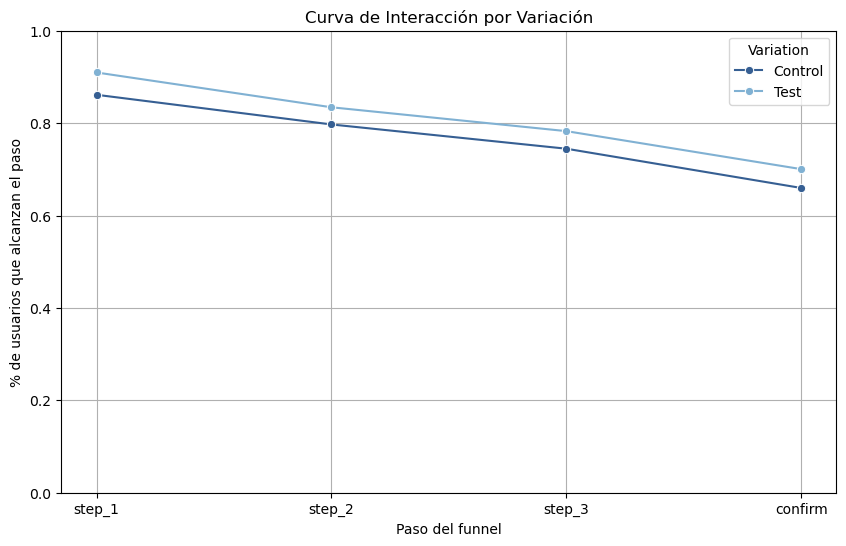

In [1032]:
step_counts = df_web_sorted[df_web_sorted['Variation'].isin(['Control', 'Test'])].groupby(['Variation', 'process_step'])['client_id'].nunique().reset_index()
step_order = ['step_1', 'step_2', 'step_3', 'confirm']
step_counts['process_step'] = pd.Categorical(step_counts['process_step'], categories=step_order, ordered=True)
step_counts = step_counts.sort_values('process_step')
totals = step_counts.groupby('Variation')['client_id'].transform('max')
step_counts['percent'] = step_counts['client_id'] / totals

plt.figure(figsize=(10, 6))
sns.lineplot(data=step_counts, x='process_step', y='percent', hue='Variation', marker='o')
plt.title('Curva de Interacción por Variación')
plt.ylabel('% de usuarios que alcanzan el paso')
plt.xlabel('Paso del funnel')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

La forma de la curva sugiere un patrón claro y estable, no ruido aleatorio.

<h3 style="color: 	#80B1D3;"><strong>Evaluación de la duración<strong></h3>

##### **¿La duración fue adecuada?**

La duración del experimento (3 meses) fue adecuada para observar resultados concluyentes. La cantidad de usuarios participantes permitió generar curvas de conversión estables y consistentes, y se observaron diferencias claras y sostenidas entre Control y Test en cada paso del funnel. Por lo tanto, el periodo experimental fue suficiente para evaluar la efectividad del rediseño.

<h3 style="color: 	#80B1D3;"><strong>Necesidades adicionales de datos<strong></h3>

**¿Qué otros datos podrían ayudar a mejorar o profundizar el análisis?**

1. Feedback cualitativo de los usuarios
Incorporar opiniones, comentarios y sugerencias directas de los usuarios puede aportar información que no se capta solo con datos cuantitativos. Por ejemplo:

- Encuestas de satisfacción tras completar (o abandonar) el proceso.

- Comentarios abiertos donde expliquen qué les gustó o qué dificultades encontraron.

Esto permite identificar puntos de dolor no evidentes en los datos técnicos y priorizar mejoras centradas en la experiencia real del usuario.

2. Datos específicos de fallos y errores técnicos en la web
Tener registros detallados de los errores que ocurren en la plataforma ayuda a entender las barreras técnicas que enfrentan los usuarios. Por ejemplo:

- Contadores automáticos de errores frecuentes (timeouts, caídas de la página, scripts que no cargan).

- Logs de errores con timestamps y contexto (por ejemplo, qué paso del funnel estaba activo cuando ocurrió el fallo).

- Datos de rendimiento web, como tiempo de carga de cada paso, latencia, y tasa de fallos en la conexión.

Esto permite correlacionar directamente errores técnicos con abandonos o repeticiones de pasos, facilitando diagnósticos precisos.

3. Datos sobre el rendimiento y estrategia de la competencia
Analizar cómo se comporta la competencia o el mercado puede aportar contexto estratégico para tu análisis, por ejemplo:


- Información sobre funcionalidades que ofrecen y cómo afectan la experiencia.

- Opiniones y valoraciones de usuarios sobre webs similares para detectar qué les gusta o disgusta.

Esto ayuda a identificar oportunidades para mejorar o diferenciar la plataforma y justificar recomendaciones basadas en estándares o prácticas exitosas.

4. Presupuesto y recursos para la nueva web
Contar con datos claros sobre el presupuesto asignado para el desarrollo, mantenimiento y mejora de la nueva web es fundamental para:

- Definir el alcance de las mejoras técnicas y funcionales posibles.

- Priorizar funcionalidades o correcciones según el costo-beneficio.

Esta información permite ajustar las recomendaciones a la realidad económica del proyecto y evitar propuestas inviables.



<h3 style="color:#80B1D3;"><strong>Conclusión Final y Recomendación</strong></h3>
El rediseño digital (grupo Test) ha demostrado mejoras estadísticamente significativas en aspectos clave del proceso, pero no cumple con todos los criterios de efectividad operativa definidos por Vanguard. A continuación se resume el balance final entre las dos versiones:

✅ **Ventajas claras del grupo Test**:
- Mayor tasa de finalización: 69.3% vs. 65.6% (diferencia significativa, p < 0.001).

- Menor tasa global de errores técnicos: 0.076% en Test frente a 0.193% en Control (p < 0.001).

- Mejora sustancial y relevante en errores críticos del paso “confirm”:

- Reducción de errores del 0.577% al 0.066% (mejora operativamente significativa de +0.51 pp, con IC del 95% mayormente por encima del umbral mínimo de mejora).

Estas mejoras hacen que el diseño Test sea más robusto y tolerante a errores, especialmente en fases críticas del proceso.

⚠️ **Limitaciones del grupo Test**:
Peor rendimiento al primer intento: 43.7% vs. 47.4% (diferencia significativa).

- Esto indica que, aunque más usuarios acaban completando el proceso, lo hacen con más fricción y menor claridad inicial.

- Tiempo medio total ligeramente mayor en Test (p < 0.001), aunque las medianas y percentiles son casi iguales, lo que sugiere eficiencia similar en términos prácticos.

- Peores tiempos en pasos clave como step_1 (+5s) y confirm (+23s), lo que puede reflejar cuellos de botella generados por el rediseño.

🧠 **Consideraciones de hipótesis y negocio**:
Aunque varias mejoras son estadísticamente significativas, no alcanzan el umbral mínimo del 5% requerido por la empresa para justificar un cambio en base a coste-beneficio.

Ejemplo: La mejora de +3.7 pp en tasa de completitud, aunque significativa, queda por debajo del umbral.

En cambio, la mejora en la reducción de errores críticos sí supera dicho umbral (retrocesos en “confirm”).

🧭 **Recomendación final**:
Se recomienda adoptar el rediseño Test, pero con ajustes, especialmente en los pasos step_1 y confirm, donde el rendimiento ha empeorado: aunque han mejorado en estabilidad al presentar menos errores, también introducen una mayor fricción, evidenciada por el aumento en el tiempo de completado.

El nuevo diseño es más estable, reduce errores técnicos y permite que más usuarios finalicen el proceso, aunque requiere mejoras en claridad y orientación inicial para elevar la tasa de éxito al primer intento.

No es un rediseño perfecto, pero es una base sólida sobre la cual iterar. Se aconseja mantener el Test como nuevo estándar, priorizando una segunda fase de optimización enfocada en los pasos que generan fricción.

<h2 style="color: 	#80B1D3;"><strong>Descarga de la Data Processed</strong></h2>

In [1033]:
#df.to_csv('df_clients.csv', index=False)
#df_bal_clean.to_csv('df_networth.csv', index=False) # Es el mismo que el df pero sin outliers.
#df_web_sorted.to_csv('df_web.csv', index=False)
#df_time_clean.to_csv('df_time_clean.csv', index=False)